In [2]:
# Standard libraries
import os
import json
import sqlite3
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Project-specific configuration
from sams.config import RAW_DATA_DIR

2025-09-23 13:25:34.465 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-09-23 13:25:34.524 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-09-23 13:25:34.524 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


## Section 1: Data Loading

In [3]:
from sams.utils import load_data
from sams.config import datasets

In [4]:
# Use the path from datasets metadata 
db_path = datasets["sams"]["path"]
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", [t[0] for t in tables])

cursor.close()
conn.close()

Tables: ['students', 'institutes']


In [ ]:
# # Connect to the database
# conn = sqlite3.connect(db_path)
# cursor = conn.cursor()

# # Delete rows for ITI module except year 2017
# print("Deleting rows start")
# cursor.execute("DELETE FROM students WHERE module = 'PDIS'")

# # Commit and close
# conn.commit()
# cursor.close()
# conn.close()

# print("Removed")

Deleting rows start
Removed


In [6]:
import sqlite3
import pandas as pd

# Connect to DB
db_path = datasets["sams"]["path"]   
conn = sqlite3.connect(db_path)

query = """
SELECT
    module,
    academic_year,
    COUNT(*) AS total_records
FROM students
GROUP BY module, academic_year
"""

df_summary = pd.read_sql_query(query, conn)
conn.close()

print("\nSummary of records in students table")
print(df_summary)



Summary of records in students table
     module  academic_year  total_records
0       DEG           2018         312823
1       DEG           2019         254342
2       DEG           2020         242661
3       DEG           2021         264152
4       DEG           2022         379911
5       DEG           2023         289849
6       DEG           2024         310753
7   Diploma           2018          64218
8   Diploma           2019          57824
9   Diploma           2020          56600
10  Diploma           2021          59278
11  Diploma           2022          78196
12  Diploma           2023          79700
13  Diploma           2024          81789
14      HSS           2018         439528
15      HSS           2019         411118
16      HSS           2020         431636
17      HSS           2021         498180
18      HSS           2022         574238
19      HSS           2023         560769
20      HSS           2024         537932
21      ITI           2017          34

In [5]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# List all columns in the students table
cursor.execute("PRAGMA table_info(students)")
columns = cursor.fetchall()

print("\nColumns in 'students' table:")
for col in columns:
    print(col[1])  # col[1] is the column name

conn.close()


Columns in 'students' table:
id
barcode
student_name
gender
religion_name
dob
nationality
annual_income
address
state
district
block
pin_code
social_category
domicile
s_domicile_category
outside_odisha_applicant_state_name
odia_applicant_living_outside_odisha_state_name
residence_barcode_number
tenth_exam_school_address
eighth_exam_school_address
highest_qualification_exam_board
board_exam_name_for_highest_qualification
highest_qualification
had_two_year_full_time_work_exp_after_tenth
gc
ph
es
sports
national_cadet_corps
pm_care
orphan
income_barcode
tfw
ews
boc
boc_regd_no
course_name
course_period
beauty_culture_type
sams_code
reported_institute
reported_branch_or_trade
institute_district
type_of_institute
phase
year
admission_status
enrollment_status
applied_status
date_of_application
application_status
aadhar_no
registration_number
mark_data
module
academic_year
contact_no
option_data
examination_board_of_the_highest_qualification
examination_type
year_of_passing
roll_no
total_mar

In [17]:
db_path = datasets["sams"]["path"]
conn = sqlite3.connect(db_path)

# Define the SQL query
# highest_qualification is '10th' overall
query = """
SELECT
    barcode,
    academic_year,
    hss_option_details,
    hss_compartments,
    compartmental_status
FROM students
WHERE module = 'HSS';
"""

# Initialize an empty list to hold the chunks
df_list = []

# Use the chunksize parameter to load data in smaller parts
chunk_size = 50000  # You can adjust this size based on your system's performance
for chunk in pd.read_sql_query(query, conn, chunksize=chunk_size):
    df_list.append(chunk)

json_df = pd.concat(df_list, ignore_index=True) # Concatenate all the chunks into a single DataFrame
conn.close()
json_df.head()

barcode  academic_year  \
0  19J0000019           2019   
1  19J0000026           2019   
2  19J0000031           2019   
3  19J0000045           2019   
4  19J0000057           2019   

                                  hss_option_details hss_compartments  \
0  [{"ReportedInstitute": "Gunupur Higher Seconda...               []   
1  [{"ReportedInstitute": "Sri Sri Jagannath High...               []   
2  [{"ReportedInstitute": "Agarpara Women's Highe...               []   
3  [{"ReportedInstitute": "Panchayat Anchalik Hig...               []   
4  [{"ReportedInstitute": "Rajdhani Higher Second...               []   

  compartmental_status  
0                   NO  
1                   NO  
2                   NO  
3                   NO  
4                   NO

In [18]:
# save df in parquet format
from pathlib import Path
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"
output_path = Path(RAW_DATA_DIR) / "json_df.parquet"
json_df.to_parquet(output_path, index=False, compression='snappy')

In [18]:
#df = pd.read_parquet(RAW_DATA_DIR / "hss_data.parquet", engine='pyarrow')
json_df = pd.read_parquet(RAW_DATA_DIR / "json_df.parquet", engine='pyarrow')

In [19]:
json_df.head()

barcode  academic_year  \
0  19J0000019           2019   
1  19J0000026           2019   
2  19J0000031           2019   
3  19J0000045           2019   
4  19J0000057           2019   

                                  hss_option_details hss_compartments  \
0  [{"ReportedInstitute": "Gunupur Higher Seconda...               []   
1  [{"ReportedInstitute": "Sri Sri Jagannath High...               []   
2  [{"ReportedInstitute": "Agarpara Women's Highe...               []   
3  [{"ReportedInstitute": "Panchayat Anchalik Hig...               []   
4  [{"ReportedInstitute": "Rajdhani Higher Second...               []   

  compartmental_status  
0                   NO  
1                   NO  
2                   NO  
3                   NO  
4                   NO

In [26]:
jsonnn_df = pd.read_parquet(RAW_DATA_DIR / "iti_applications.pq", engine='pyarrow')

In [27]:
jsonnn_df.columns

Index(['barcode', 'aadhar_no', 'gender', 'dob', 'annual_income', 'state',
       'district', 'social_category', 'domicile', 'date_of_application',
       'academic_year', 'year', 'course_name', 'course_period',
       'reported_institute', 'reported_branch_or_trade', 'institute_district',
       'type_of_institute', 'highest_qualification', 'gc', 'ph', 'es',
       'sports', 'national_cadet_corps', 'orphan', 'ews', 'admission_status',
       'enrollment_status', 'phase', 'option_no', 'institute_name', 'trade',
       'status', 'num_applications'],
      dtype='object')

In [ ]:
js

In [19]:
json_df.columns

Index(['barcode', 'academic_year', 'hss_option_details', 'hss_compartments',
       'compartmental_status'],
      dtype='object')

In [9]:
df.columns

Index(['barcode', 'academic_year', 'gender', 'dob', 'nationality', 'address',
       'state', 'district', 'block', 'pin_code', 'social_category', 'ph', 'es',
       'sports', 'examination_boardofthe_highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'gender_clean'],
      dtype='object')

In [34]:
conn = sqlite3.connect(db_path)

query = """
SELECT
    barcode,
    aadhar_no,
    gender,
    dob,
    annual_income,
    state,
    district,
    social_category,
    domicile,
    date_of_application,
    academic_year,
    year,
    course_name,
    course_period,
    reported_institute,
    reported_branch_or_trade,
    institute_district,
    type_of_institute,
    highest_qualification,
    gc,
    ph,
    es,
    sports,
    national_cadet_corps,
    orphan,
    ews,
    admission_status,
    enrollment_status,
    phase,
    option_data
FROM students
WHERE module = 'ITI' AND academic_year = 2017;
"""

students_df = pd.read_sql_query(query, conn)
conn.close()

students_df.head()

barcode                                     aadhar_no gender  \
0  17T0181047  DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=   Male   
1  17T0114510  6/Vau/OfdeJ6NAV7iD6bmnbzGEexPB8LP/JcN1eroCs=   Male   
2  17T0346747  EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=   Male   
3  17T0288737  yg4tiEAGopVFYnXgybQlTen34PqwEI08id2hvZS9spw=   Male   
4  17T0151332  5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=   Male   

           dob annual_income   state   district      social_category domicile  \
0  01-Jan-2002    0-1,00,000  Odisha      Angul  Schedule Caste (SC)       NA   
1  20-Apr-2000    0-1,00,000  Odisha  Dhenkanal              General       NA   
2  07-Oct-2001    0-1,00,000  Odisha  Dhenkanal             OBC/SEBC       NA   
3  05-Nov-1999    0-1,00,000  Odisha  Dhenkanal  Schedule Caste (SC)       NA   
4  20-Apr-1999    0-1,00,000  Odisha    Deogarh  Schedule Tribe (ST)       NA   

  date_of_application  ...  ph  es sports national_cadet_corps orphan ews  \
0         01-Jun-2017  ...  No  No     No                   NA     No  NA   
1         26-May-2017  ...  No  No     No                   NA     No  NA   
2         20-Jul-2017  ...  No  No     No                   NA     No  NA   
3         08-Jun-2017  ...  No  No     No                   NA     No  NA   
4         30-May-2017  ...  No  No     No                   NA     No  NA   

  admission_status enrollment_status phase  \
0              Yes               Yes  None   
1              Yes               Yes  None   
2              Yes               Yes  None   
3              Yes               Yes  None   
4              Yes               Yes  None   

                                         option_data  
0  [{"Phase": "1", "Option_No": "1", "Institute_N...  
1  [{"Phase": "1", "Option_No": "1", "Institute_N...  
2  [{"Phase": "1", "Option_No": "1", "Institute_N...  
3  [{"Phase": "1", "Option_No": "1", "Institute_N...  
4  [{"Phase": "1", "Option_No": "1", "Institute_N...  

[5 rows x 30 columns]

In [ ]:
# save df in parquet format
from pathlib import Path
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"
output_path = Path(RAW_DATA_DIR) / "hss_data.pq"
df.to_parquet(output_path, index=False, compression='snappy')

In [13]:
df.shape

(3453401, 27)

In [15]:
# Numeric conversions
df['year_of_passing'] = pd.to_numeric(df['year_of_passing'], errors='coerce').astype('Int16')
df['academic_year'] = pd.to_numeric(df['academic_year'], errors='coerce').astype('Int16')
df['total_marks'] = pd.to_numeric(df['total_marks'], errors='coerce').astype('Int16')
df['secured_marks'] = pd.to_numeric(df['secured_marks'], errors='coerce').astype('Float32')
df['percentage'] = pd.to_numeric(df['percentage'], errors='coerce').astype('Float32')

# Convert to string (for IDs)
df['barcode'] = df['barcode'].astype('string')

# Convert to category
category_cols = [
    'gender', 'nationality', 'state', 'district', 'block',
    'social_category', 'board_exam_namefor_highest_qualification',
    'examination_type', 'compartmental_status'
]
for col in category_cols:
    df[col] = df[col].astype('category')

In [16]:
mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"DataFrame uses {mem_mb:.2f} MB of memory")

DataFrame uses 3045.08 MB of memory


In [17]:
df.columns

Index(['barcode', 'student_name', 'academic_year', 'gender', 'dob',
       'nationality', 'annual_income', 'address', 'state', 'district', 'block',
       'pin_code', 'social_category', 'highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'roll_no', 'total_marks', 'secured_marks',
       'percentage', 'compartmental_status', 'ph', 'es', 'sports',
       'national_cadet_corps', 'orphan'],
      dtype='object')

In [49]:
df['social_category'].value_counts()

social_category
GEN     815136
ST      772328
OBC     768815
SC      605131
SEBC    491991
Name: count, dtype: int64

## Working with both json columns

In [ ]:
# Get duplicate barcode rows
dup_barcodes = df[df.duplicated(subset='barcode', keep=False)]

print(f"Duplicate barcode rows: {dup_barcodes.shape[0]}")
display(dup_barcodes.sort_values('barcode'))

Duplicate barcode rows: 4


barcode  academic_year  gender nationality   state  district  \
797732  18J4111204           2018  Female      Indian  Odisha    Jajpur   
797733  18J4111204           2018  Female      Indian  Odisha     Boudh   
298269  19J3085956           2019    Male      Indian  Odisha  Balasore   
298270  19J3085956           2019    Male      Indian  Odisha  Balasore   

            block social_category  \
797732    Sukinda             OBC   
797733  Harbhanga             OBC   
298269     Remuna             GEN   
298270     Remuna             GEN   

       examination_boardofthe_highest_qualification  \
797732                                  BSE, Odisha   
797733                                  BSE, Odisha   
298269                                  BSE, Odisha   
298270                                  BSE, Odisha   

                 board_exam_namefor_highest_qualification examination_type  \
797732  Board of Secondary Education, Orissa, Cuttack-...           Annual   
797733  Board of Secondary Education, Orissa, Cuttack-...           Annual   
298269  Board of Secondary Education, Orissa, Cuttack-...           Annual   
298270  Board of Secondary Education, Orissa, Cuttack-...           Annual   

        year_of_passing  total_marks  secured_marks  percentage  \
797732             2018          600          519.0        86.5   
797733             2018          600          435.0        72.5   
298269             2019          600          360.0        60.0   
298270             2019          600          360.0        60.0   

       compartmental_status                                 hss_option_details  
797732                   NO  [{"ReportedInstitute": "Institute of Higher Se...  
797733                   NO  [{"ReportedInstitute": "Institute of Higher Se...  
298269                   NO                                                 []  
298270                   NO  [{"ReportedInstitute": "Sahid Memorial Higher ...

In [ ]:
def parse_option_data(val):
    try: return json.loads(val) if isinstance(val, str) else val or []
    except json.JSONDecodeError: return []

# Extract and clean duplicates
dups = df[df.duplicated('barcode', keep=False)].copy()
dups['valid'] = dups['hss_option_details'].apply(lambda x: len(parse_option_data(x)) > 0)

# Keep best row per barcode (with valid options)
cleaned = dups.sort_values(by='valid', ascending=False).drop_duplicates('barcode')

# Replace old duplicates with cleaned ones
df = df[~df['barcode'].isin(dups['barcode'])]
df = pd.concat([df, cleaned.drop(columns='valid')], ignore_index=True)

print("Remaining duplicate barcodes:", df.duplicated('barcode').sum())

Remaining duplicate barcodes: 0


In [ ]:
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"

def parse_json(x):
    try: return json.loads(x) if pd.notnull(x) and x.strip() else [None]
    except: return [None]

def save_option_details_by_year(start, end):
    conn = sqlite3.connect(db_path)

    for year in range(start, end + 1):
        print(f"Processing {year}...")
        query = f"""
            SELECT barcode, academic_year, hss_option_details
            FROM students
            WHERE module = 'HSS' AND academic_year = {year}
        """
        chunks, total_rows = [], 0
        for chunk in pd.read_sql_query(query, conn, chunksize=50000):
            chunk['hss_option_details'] = chunk['hss_option_details'].apply(parse_json)
            exploded = chunk.explode('hss_option_details').reset_index(drop=True)
            norm = pd.json_normalize(exploded['hss_option_details'])
            final = pd.concat([exploded.drop('hss_option_details', axis=1), norm], axis=1)
            chunks.append(final)
            total_rows += len(final)
        if chunks:
            pd.concat(chunks).to_parquet(RAW_DATA_DIR / f"hss_option_details_{year}.parquet", engine='pyarrow')
        print(f"Saved {year}: {total_rows} rows")

    conn.close()
    print("All years done.")

# Run
save_option_details_by_year(2018, 2024)


Loading data for 2018...
Saved data for 2018 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2018.parquet
Loading data for 2019...
Saved data for 2019 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2019.parquet
Loading data for 2020...
Saved data for 2020 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2020.parquet
Loading data for 2021...
Saved data for 2021 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2021.parquet
Loading data for 2022...
Saved data for 2022 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2022.parquet
Loading data for 2023...
Saved data for 2023 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2023.parquet
Loading data for 2024...
Saved data for 2024 at C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2024.parquet


In [ ]:
# Set up the raw data directory

# Function to merge all Parquet files and save them into one
def merge_parquet_files():
    # Get a list of all Parquet files in the RAW_DATA_DIR
    parquet_files = list(RAW_DATA_DIR.glob("hss_option_*.parquet"))
    
    # Initialize an empty list to hold the dataframes
    df_list = []
    
    # Load each Parquet file and append to the list
    for file in parquet_files:
        print(f"Loading file: {file}")
        df = pd.read_parquet(file, engine='pyarrow')  
        df_list.append(df)
    
    # Concatenate all DataFrames into one
    merged_df = pd.concat(df_list, ignore_index=True)
    
    merged_file = RAW_DATA_DIR / "hss_option_merged.parquet"
    merged_df.to_parquet(merged_file, engine='pyarrow')
    print(f"All files merged and saved as: {merged_file}")

# Call the function to merge the files
merge_parquet_files()

Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2018.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2019.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2020.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2021.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2022.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2023.parquet
Loading file: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_2024.parquet
All files merged and saved as: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_option_merged.parquet


In [6]:
# Read the merged Parquet file
merged_df = pd.read_parquet(RAW_DATA_DIR / "hss_option_merged.parquet", engine='pyarrow')

print(merged_df.shape) 
print(merged_df.columns)  

(18323932, 11)
Index(['barcode', 'ReportedInstitute', 'SAMSCode', 'Stream',
       'InstituteDistrict', 'InstituteBlock', 'TypeofInstitute', 'Phase',
       'Year', 'AdmissionStatus', 'OptionNo'],
      dtype='object')


In [61]:
import pandas as pd, sqlite3, json
from pathlib import Path

# Define data paths
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"

# JSON parser for the 'hss_compartments' column
def parse_json(x):
    try:
        return json.loads(x) if pd.notnull(x) and x.strip() else [None]
    except json.JSONDecodeError:
        return [None]

# Processing function
def process_and_save_compartment_data(start, end):
    conn = sqlite3.connect(db_path)

    for year in range(start, end + 1):
        print(f"\nProcessing academic year {year}...")
        
        query = f"""
            SELECT barcode, academic_year, hss_compartments
            FROM students
            WHERE module = 'HSS' AND academic_year = {year}
        """

        df_chunks = []

        for chunk in pd.read_sql_query(query, conn, chunksize=50000):
            chunk['hss_compartments'] = chunk['hss_compartments'].apply(parse_json)
            exploded = chunk.explode('hss_compartments').reset_index(drop=True)
            norm = pd.json_normalize(exploded['hss_compartments'])
            combined = pd.concat([exploded.drop('hss_compartments', axis=1), norm], axis=1)
            df_chunks.append(combined)

        if df_chunks:
            final = pd.concat(df_chunks, ignore_index=True)
            out_path = RAW_DATA_DIR / f"hss_compartments_{year}.parquet"
            final.to_parquet(out_path, engine='pyarrow')
            print(f"Saved: {out_path} | Rows: {len(final)}")
        else:
            print(f"No data found for {year}")

    conn.close()
    print("\nAll years processed and saved.")

# Example usage
process_and_save_compartment_data(2018, 2024)



Processing academic year 2018...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2018.parquet | Rows: 443424

Processing academic year 2019...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2019.parquet | Rows: 413625

Processing academic year 2020...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2020.parquet | Rows: 432950

Processing academic year 2021...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2021.parquet | Rows: 498861

Processing academic year 2022...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2022.parquet | Rows: 574666

Processing academic year 2023...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2023.parquet | Rows: 561541

Processing academic year 2024...
Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2024.parquet | Rows: 538464

All years processed and saved.


In [62]:
from pathlib import Path
import pandas as pd

RAW_DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data/raw")

def merge_hss_compartments():
    files = list(RAW_DATA_DIR.glob("hss_compartments_*.parquet"))
    if not files:
        print("No files found.")
        return

    df = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
    output_file = RAW_DATA_DIR / "hss_comp.parquet"
    df.to_parquet(output_file, engine='pyarrow')
    print(f"Saved: {output_file}")

merge_hss_compartments()

Saved: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_comp.parquet


In [63]:
# Read the merged Parquet file
merged_df = pd.read_parquet(RAW_DATA_DIR / "hss_comp.parquet", engine='pyarrow')

print(merged_df.shape) 
print(merged_df.columns)  

(3463531, 5)
Index(['barcode', 'academic_year', 'COMPSubject', 'COMPFailMark',
       'COMPPassMark'],
      dtype='object')


In [7]:
from pathlib import Path
import shutil

# Define original data path
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"


# Define new target folder
TARGET_DIR = RAW_DATA_DIR / "hss_compartments_pq"
TARGET_DIR.mkdir(exist_ok=True)  # Create folder if it doesn't exist

# List of years you want to move
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Move each file to the new folder
for year in years:
    original_file = RAW_DATA_DIR / f"hss_compartments_{year}.parquet"
    target_file = TARGET_DIR / f"hss_compartments_{year}.parquet"
    if original_file.exists():
        shutil.move(str(original_file), str(target_file))
        print(f"Moved: {original_file.name} → {TARGET_DIR}")
    else:
        print(f"File not found: {original_file}")


File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2018.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2019.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2020.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2021.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2022.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2023.parquet
File not found: C:\Users\Admin\Documents\GitHub\sams\data\raw\hss_compartments_2024.parquet


## Definig a variable for laoded json column (pq format)

In [1]:
# Read the merged Parquet file
option_df = pd.read_parquet(RAW_DATA_DIR / "hss_applications.pq", engine='pyarrow')
#comp_df = pd.read_parquet(RAW_DATA_DIR / "hss_compartment.pq", engine='pyarrow')
#df = pd.read_parquet(RAW_DATA_DIR / "hss_data.pq", engine='pyarrow')

NameError: name 'pd' is not defined

In [5]:
df.columns

Index(['aadhar_no', 'barcode', 'academic_year', 'gender', 'nationality',
       'state', 'district', 'block', 'pin_code', 'social_category',
       'examination_boardofthe_highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details'],
      dtype='object')

In [16]:
option_df.columns

Index(['aadhar_no', 'barcode', 'academic_year', 'reported_institute',
       'sams_code', 'stream', 'institute_district', 'institute_block',
       'type_of_institute', 'phase', 'year', 'admission_status', 'option_no',
       'num_applications'],
      dtype='object')

In [17]:
option_df.head()

aadhar_no     barcode  academic_year  \
0      <NA>  18J0000045           2018   
1      <NA>  18J0000045           2018   
2      <NA>  18J0000045           2018   
3      <NA>  18J0000045           2018   
4      <NA>  18J0000045           2018   

                                  reported_institute sams_code    stream  \
0  Gangadhar Meher Higher Secondary School, Samba...  28141101  Commerce   
1  Netaji Subash Chandra Bose Higher Secondary Sc...  28111101  Commerce   
2           Hirakud Higher Secondary School, Hirakud  28132101  Commerce   
3         Surajmal Higher Secondary School, Rampella  28112102  Commerce   
4        Burla N.A.C. Higher Secondary School, Burla  28122101  Commerce   

  institute_district institute_block                type_of_institute phase  \
0          Sambalpur  Sambalpur (MC)                      Govt. (SME)     1   
1          Sambalpur         Rengali                      Govt. (SME)     1   
2          Sambalpur   Hirakud (NAC)  Non-Govt Aided (488 Categories)     1   
3          Sambalpur         Rengali  Non-Govt Aided (488 Categories)     1   
4          Sambalpur     Burla (NAC)  Non-Govt Aided (488 Categories)     1   

   year admission_status option_no  num_applications  
0  2018         TC TAKEN         1                 5  
1  2018     NOT SELECTED         2                 5  
2  2018     NOT SELECTED         3                 5  
3  2018     NOT SELECTED         4                 5  
4  2018     NOT SELECTED         5                 5

In [ ]:
option_df['option_no'].dtype

dtype('O')

In [ ]:
option_df['option_no'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13',
       None, '12', '14', '15', '16', '17', '18', '19', 'SPOT - 1',
       'SPOT - 2', 'SPOT - 3', 'SPOT - 4', 'SPOT - 5', 'SPOT - 6',
       'SPOT - 7', 'SPOT - 8', 'SPOT - 9', 'SPOT - 10', '20', 'SPOT - 11',
       'SPOT - 12', 'SPOT - 13', 'SPOT - 14', 'SPOT - 15', '21', '22',
       'SPOT - 16', 'SPOT - 17', 'SPOT - 18', 'SPOT - 19', 'SPOT - 20',
       'SPOT - 21', 'SPOT - 22', 'SPOT - 23', '23', '24', '25', '26',
       '27', 'SPOT - 24', '28', '29', '30', 'SPOT - 25', 'SPOT - 26',
       'SPOT - 27', 'SPOT - 28', 'SPOT - 29', 'SPOT - 30', 'SPOT - 31',
       'SPOT - 32', 'SPOT - 33', 'SPOT - 34', 'SPOT - 35', 'SPOT - 36',
       '31', '32', '33', '34', '35', '36', '37', '38'], dtype=object)

In [23]:
hss_first_choice_admission = (
    option_df[option_df['option_no'] == '1']
    .drop(columns=['num_applications'])
    .reset_index(drop=True)
)
hss_first_choice_admission.head()

aadhar_no     barcode  academic_year  \
0      <NA>  18J0000045           2018   
1      <NA>  18J0000057           2018   
2      <NA>  18J0000067           2018   
3      <NA>  18J0000075           2018   
4      <NA>  18J0000081           2018   

                                  reported_institute sams_code    stream  \
0  Gangadhar Meher Higher Secondary School, Samba...  28141101  Commerce   
1  Regional Women's Higher Secondary School, Polo...  11389201      Arts   
2     Government Higher Secondary School, Sundargarh  30211101      Arts   
3  Ballavi Devi Mahila Higher Secondary School, N...  07149201      Arts   
4               Jiral Higher Secondary School, Jiral  09062101      Arts   

  institute_district   institute_block                type_of_institute phase  \
0          Sambalpur    Sambalpur (MC)                      Govt. (SME)     1   
1             Ganjam    Polasara (NAC)  Non-Govt Aided (662 Categories)     1   
2         Sundargarh  Sundargarh (MPL)                      Govt. (SME)     1   
3            Cuttack    Nischintakoili  Non-Govt Aided (662 Categories)     1   
4          Dhenkanal            Bhuban  Non-Govt Aided (488 Categories)     1   

   year admission_status option_no  
0  2018         TC TAKEN         1  
1  2018     NOT SELECTED         1  
2  2018     NOT SELECTED         1  
3  2018         TC TAKEN         1  
4  2018         TC TAKEN         1

In [24]:
# Save to Parquet
hss_first_choice_admission.to_parquet("hss_first_choice_admission.pq", index=False)


In [17]:
import pandas as pd

# 1. Rename columns in option_df
option_df = option_df.rename(columns={
    'ReportedInstitute': 'reported_institute',
    'SAMSCode': 'sams_code',
    'Stream': 'stream',
    'InstituteDistrict': 'institute_district',
    'InstituteBlock': 'institute_block',
    'TypeofInstitute': 'type_of_institute',
    'Phase': 'phase',
    'Year': 'year',
    'AdmissionStatus': 'admission_status',
    'OptionNo': 'option_no',
    'barcode': 'barcode'
})

# 2. Create num_applications column
option_df['num_applications'] = option_df.groupby('barcode')['option_no'].transform('count')

# 3. Create df_subset from df
df_subset = df[['aadhar_no', 'barcode', 'academic_year']]

# 4. Merge on barcode
hss_applications = pd.merge(option_df, df_subset, on='barcode', how='left')

# 5. Arrange columns in a nice order
final_cols = [
    'aadhar_no', 'barcode', 'academic_year', 'reported_institute', 'sams_code', 
    'stream', 'institute_district', 'institute_block', 'type_of_institute', 'phase', 'year',
    'admission_status', 'option_no', 'num_applications'
]

hss_applications = hss_applications[final_cols]

# hss_applications is now the final cleaned dataset
hss_applications.columns

Index(['aadhar_no', 'barcode', 'academic_year', 'reported_institute',
       'sams_code', 'stream', 'institute_district', 'institute_block',
       'type_of_institute', 'phase', 'year', 'admission_status', 'option_no',
       'num_applications'],
      dtype='object')

In [18]:
# save df in parquet format
from pathlib import Path
DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
RAW_DATA_DIR = DATA_DIR / "raw"
output_path = Path(RAW_DATA_DIR) / "hss_applications.pq"
hss_applications.to_parquet(output_path, index=False, compression='snappy')

In [12]:
# Merge on 'barcode'
merged_df = df.merge(option_df, on='barcode', how='left')

# Select relevant columns (optional)
columns_to_keep = [
    'barcode', 'aadhar_no', 'academic_year', 'total_marks', 'secured_marks', 'percentage',
    'compartmental_status',
    'ReportedInstitute', 'SAMSCode', 'Stream', 'TypeofInstitute',
    'AdmissionStatus', 'OptionNo'
]
final_df = merged_df[columns_to_keep]

In [ ]:
final_df

In [18]:
# Group by year and student, count how many options each student submitted
options_per_student = final_df.groupby(['academic_year', 'barcode']).size().reset_index(name='num_options')

# For each year, find the max number of options submitted by any student
max_options_per_year = options_per_student.groupby('academic_year')['num_options'].max().reset_index()
max_options_per_year.columns = ['year', 'max_options_per_student']

print("Max options selected by a student each year:")
print(max_options_per_year)


Max options selected by a student each year:
   year  max_options_per_student
0  2018                       11
1  2019                       12
2  2020                       11
3  2021                       11
4  2022                       19
5  2023                       65
6  2024                       45


In [19]:
# Reuse the options_per_student from above
summary_stats = options_per_student.groupby('academic_year')['num_options'].agg(
    students='count',             # number of students
    applications='sum',           # total number of application records
    std_deviation='std'           # standard deviation
).reset_index()

summary_stats.columns = ['year', 'students', 'applications', 'std_deviation']

print("Yearly summary: students, total applications, and standard deviation of applications per student:")
print(summary_stats)


Yearly summary: students, total applications, and standard deviation of applications per student:
   year  students  applications  std_deviation
0  2018    439527       2237159       0.948562
1  2019    411117       2060037       1.369966
2  2020    431636       2280404       1.066740
3  2021    498180       2591931       1.043220
4  2022    574238       3002358       1.158396
5  2023    560769       3110640       2.009177
6  2024    537932       3041411       1.907979


In [22]:
import pandas as pd

# STEP 1: Group by student and year, count number of applications
app_counts = final_df.groupby(['aadhar_no', 'academic_year'])['OptionNo'].count().reset_index()
app_counts.rename(columns={'OptionNo': 'num_applications'}, inplace=True)

# STEP 2: Identify outliers (students with 0 or > 50 applications)
outliers = app_counts[(app_counts['num_applications'] == 0) | (app_counts['num_applications'] > 50)]

# STEP 3: Remove outliers
cleaned_app_counts = app_counts[(app_counts['num_applications'] > 0) & (app_counts['num_applications'] <= 50)]

# STEP 4: Summary stats per academic year
summary = cleaned_app_counts.groupby('academic_year')['num_applications'].agg(
    students='count',
    applications='sum',
    std_deviation='std'
).reset_index()

# Optional: Display output
summary
# (Optional) view some outliers if needed
# display(outliers.sort_values(by='num_applications', ascending=False).head(10))


academic_year  students  applications  std_deviation
0           2018    367552       1971747       1.475129
1           2019    353040       1872549       1.034837
2           2020    341760       1958908       1.860586
3           2021    375279       2129459       1.816329
4           2022    416961       2548706       2.623235
5           2023    419044       2664180       3.151813
6           2024    473004       2944598       2.764833

In [24]:
app_counts = final_df.groupby(['aadhar_no', 'academic_year'])['OptionNo'].count().reset_index()
app_counts.rename(columns={'OptionNo': 'num_applications'}, inplace=True)

# Only filter out students who submitted 0 applications
cleaned_app_counts = app_counts[app_counts['num_applications'] > 0]

In [25]:
# Create bins
bins = [1, 5, 10, 20, 50, 100, 500, 10000]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–500', '500+']
app_counts['option_bin'] = pd.cut(app_counts['num_applications'], bins=bins, labels=labels, right=True)

# Count how many students fall in each bin
distribution = app_counts['option_bin'].value_counts().sort_index().reset_index()
distribution.columns = ['Range of Applications', 'Number of Students']


In [26]:
distribution

Range of Applications  Number of Students
0                   1–5             2056032
1                  6–10              552979
2                 11–20              102514
3                 21–50                6226
4                51–100                  16
5               101–500                   1
6                  500+                   0

In [27]:
# Step 1: Group by student and year to count number of applications
app_counts = final_df.groupby(['aadhar_no', 'academic_year'])['OptionNo'].count().reset_index()
app_counts.rename(columns={'OptionNo': 'num_applications'}, inplace=True)

# Step 2: Filter out only extreme cases (optional, based on your comfort)
filtered_app_counts = app_counts[app_counts['num_applications'] <= 100]

# Step 3: Recalculate summary statistics
revised_summary = filtered_app_counts.groupby('academic_year')['num_applications'].agg(
    students='count',
    applications='sum',
    std_deviation='std'
).reset_index()

# Step 4: Display result
revised_summary

academic_year  students  applications  std_deviation
0           2018    367580       1971747       1.475816
1           2019    355307       1872629       1.121629
2           2020    341821       1958908       1.861995
3           2021    375367       2129459       1.818193
4           2022    417039       2548832       2.627288
5           2023    419133       2664708       3.162109
6           2024    473096       2944918       2.774612

In [30]:
# Group by student and year to count number of applications
app_counts = final_df.groupby(['aadhar_no', 'academic_year'])['OptionNo'].count().reset_index()
app_counts.rename(columns={'OptionNo': 'num_applications'}, inplace=True)

# Filter students with more than 100 applications
students_over_100 = app_counts[app_counts['num_applications'] > 100]

# Optional: Merge back with original dataset to see their full records
over_100_details = final_df.merge(students_over_100, on=['aadhar_no', 'academic_year'], how='inner')

# Display the filtered records
over_100_details.head()

barcode aadhar_no  academic_year  total_marks  secured_marks  \
0  19J0052650                     2019          600          256.0   
1  19J0052650                     2019          600          256.0   
2  19J0052650                     2019          600          256.0   
3  19J0052650                     2019          600          256.0   
4  19J0052650                     2019          600          256.0   

   percentage compartmental_status  \
0   42.669998                   NO   
1   42.669998                   NO   
2   42.669998                   NO   
3   42.669998                   NO   
4   42.669998                   NO   

                                   ReportedInstitute  SAMSCode Stream  \
0           Kesinga Higher Secondary School, Kesinga  15092101   Arts   
1             Utkela Higher Secondary School, Utkela  15039106   Arts   
2     Kashrupada Higher Secondary School, Kashrupada  15039105   Arts   
3  Panchayat Samiti Higher Secondary School, Karl...  15012102   Arts   
4   Government Higher Secondary School, Bhawanipatna  15081101   Arts   

                   TypeofInstitute AdmissionStatus OptionNo  num_applications  
0  Non-Govt Aided (488 Categories)        TC TAKEN        1            141574  
1  Non-Govt Aided (662 Categories)    NOT SELECTED        2            141574  
2  Non-Govt Aided (662 Categories)    NOT SELECTED        3            141574  
3  Non-Govt Aided (488 Categories)    NOT SELECTED        4            141574  
4                      Govt. (SME)    NOT SELECTED        5            141574

In [5]:
option_df.head()

barcode                                  ReportedInstitute  SAMSCode  \
0  18J0000045  Gangadhar Meher Higher Secondary School, Samba...  28141101   
1  18J0000045  Netaji Subash Chandra Bose Higher Secondary Sc...  28111101   
2  18J0000045           Hirakud Higher Secondary School, Hirakud  28132101   
3  18J0000045         Surajmal Higher Secondary School, Rampella  28112102   
4  18J0000045        Burla N.A.C. Higher Secondary School, Burla  28122101   

     Stream InstituteDistrict  InstituteBlock  \
0  Commerce         Sambalpur  Sambalpur (MC)   
1  Commerce         Sambalpur         Rengali   
2  Commerce         Sambalpur   Hirakud (NAC)   
3  Commerce         Sambalpur         Rengali   
4  Commerce         Sambalpur     Burla (NAC)   

                   TypeofInstitute Phase  Year AdmissionStatus OptionNo  
0                      Govt. (SME)     1  2018        TC TAKEN        1  
1                      Govt. (SME)     1  2018    NOT SELECTED        2  
2  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        3  
3  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        4  
4  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        5

In [6]:
option_df.columns

Index(['barcode', 'ReportedInstitute', 'SAMSCode', 'Stream',
       'InstituteDistrict', 'InstituteBlock', 'TypeofInstitute', 'Phase',
       'Year', 'AdmissionStatus', 'OptionNo'],
      dtype='object')

In [ ]:
summary_df = (
    option_df.groupby("Year")
    .agg(
        applicants=("barcode", "nunique"),     # unique students
        applications=("barcode", "count")      # total choices (options)
    )
    .reset_index()
    .sort_values("Year")
)

print(summary_df)

   Year  applicants  applications
0  2018      439288       2236918
1  2019      390432       2039345
2  2020      431357       2280125
3  2021      497488       2591239
4  2022      573911       3002031
5  2023      560363       3110234
6  2024      537230       3040709
7   219           1             1


In [ ]:
import pandas as pd

# Step 1: Drop rows where barcode or Year is missing
option_df = option_df.dropna(subset=['barcode', 'Year'])

# Step 2: Ensure Year is string or consistent format
option_df['Year'] = option_df['Year'].astype(str)

# Step 3: Count unique barcodes per year (i.e., student registrations)
student_counts = option_df.groupby('Year')['barcode'].nunique().reset_index()

# Step 4: Rename columns for clarity
student_counts.columns = ['academic_year', 'total_records']

# Step 5: Sort by year
student_counts = student_counts.sort_values('academic_year')

# Display result
print(student_counts)

  academic_year  total_records
0          2018         439288
1          2019         390432
2          2020         431357
3          2021         497488
4          2022         573911
5          2023         560363
6          2024         537230
7           219              1
8          None          23330


In [10]:
option_df.columns

Index(['barcode', 'ReportedInstitute', 'SAMSCode', 'Stream',
       'InstituteDistrict', 'InstituteBlock', 'TypeofInstitute', 'Phase',
       'Year', 'AdmissionStatus', 'OptionNo'],
      dtype='object')

In [30]:
print("=== Admission Status Summary (by student) ===")

# Step 1: Drop duplicates so each student is counted once per status
unique_students = option_df.drop_duplicates(subset=['barcode', 'AdmissionStatus'])

# Step 2: Normalize string "None" to actual NaN
unique_students['AdmissionStatus'] = unique_students['AdmissionStatus'].replace("None", pd.NA)

# Step 3: Total unique students (barcodes)
total_students = unique_students['barcode'].nunique()
print(f"Total unique students (barcodes): {total_students}")

# Step 4: Missing AdmissionStatus (student level)
missing_student_count = unique_students['AdmissionStatus'].isna().sum()
print(f"Students with missing AdmissionStatus: {missing_student_count}")

# Step 5: Count unique students per AdmissionStatus (non-missing)
student_status_counts = unique_students.dropna(subset=['AdmissionStatus']) \
                                       .groupby('AdmissionStatus')['barcode'] \
                                       .nunique()

# Step 6: Print results
for status, count in student_status_counts.items():
    print(f"{status}: {count}")


=== Admission Status Summary (by student) ===


C:\Users\Admin\AppData\Local\Temp\ipykernel_11412\1751096006.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_students['AdmissionStatus'] = unique_students['AdmissionStatus'].replace("None", pd.NA)


Total unique students (barcodes): 3453399
Students with missing AdmissionStatus: 23330
ADMITTED: 874279
NOT SELECTED: 3353578
SELECTED BUT NOT ADMITTED: 549510
TC TAKEN: 1920848


In [ ]:
import pandas as pd

# Step 1: Filter only first-choice applications
# Fix the type if needed
option_df['OptionNo'] = option_df['OptionNo'].astype(str)
first_choice_df = option_df[option_df['OptionNo'] == '1'].copy()

# Step 2: Normalize AdmissionStatus values
first_choice_df['AdmissionStatus'] = first_choice_df['AdmissionStatus'].replace("None", pd.NA)

# Step 3: Drop rows with missing year or barcode
first_choice_df = first_choice_df.dropna(subset=['Year', 'barcode'])

# Step 4: Ensure Year is string for grouping
first_choice_df['Year'] = first_choice_df['Year'].astype(str)

# Step 5: Total applicants = unique barcodes for Option 1 per year
applicant_count = first_choice_df.groupby('Year')['barcode'].nunique().rename('Applicants')

# Step 6: Count unique students per AdmissionStatus for Option 1 per year
status_counts = first_choice_df.drop_duplicates(subset=['barcode', 'Year', 'AdmissionStatus']) \
    .groupby(['Year', 'AdmissionStatus'])['barcode'].nunique().unstack(fill_value=0)

# Step 7: Rename columns for reporting
column_rename_map = {
    'ADMITTED': 'Admitted',
    'NOT SELECTED': 'Not Selected',
    'SELECTED BUT NOT ADMITTED': 'Selected, Not Admitted',
    'TC TAKEN': 'TC Taken'
}
status_counts = status_counts.rename(columns=column_rename_map)

summary_df = pd.concat([applicant_count.to_frame(), status_counts], axis=1).reset_index()
summary_df = summary_df.sort_values(by='Year')
summary_df

   Year  Applicants  Admitted  Not Selected  Selected, Not Admitted  TC Taken
0  2018      439242     64894        126692                   24822    222834
1  2019      390241     30038         80531                   33598    246074
2  2020      431303     37889        104477                   51251    237686
3  2021      497458     53124        160242                   41660    242432
4  2022      573881     49086        237731                   38473    248591
5  2023      560231     75579        192667                   53235    243339
6  2024      536855    321851        163896                   47594      7304
7   219           1         0             0                       0         1


In [43]:
import pandas as pd

#Clean up AdmissionStatus
option_df['AdmissionStatus'] = option_df['AdmissionStatus'].replace("None", pd.NA)

#Drop rows missing Year or barcode
option_df = option_df.dropna(subset=['barcode', 'Year'])

#Ensure Year is string
option_df['Year'] = option_df['Year'].astype(str)

#Create boolean column: was this row an admission?
option_df['IsAdmitted'] = option_df['AdmissionStatus'] == 'ADMITTED'

#Keep only one row per student per year (True if admitted anywhere)
student_flags = option_df.groupby(['barcode', 'Year'])['IsAdmitted'].max().reset_index()

#Final summary
summary_df = student_flags.groupby('Year')['IsAdmitted'] \
    .agg(Total_Students='count', Admitted_Students='sum') \
    .reset_index()

summary_df

Year  Total_Students  Admitted_Students
0  2018          439288              88756
1  2019          390432              40204
2  2020          431357              52656
3  2021          497488              77708
4  2022          573911              76381
5  2023          560363             110004
6  2024          537230             428570
7   219               1                  0
8  None           23330                  0

In [44]:
summary_df = student_flags.groupby('Year')['IsAdmitted'] \
    .agg(**{
        'No. of Students': 'count',
        'Admitted Students': 'sum'
    }).reset_index()
summary_df

Year  No. of Students  Admitted Students
0  2018           439288              88756
1  2019           390432              40204
2  2020           431357              52656
3  2021           497488              77708
4  2022           573911              76381
5  2023           560363             110004
6  2024           537230             428570
7   219                1                  0
8  None            23330                  0

In [ ]:
missing_rows_count = option_df.isnull().any(axis=1).sum()
print(f"Rows with any missing values: {missing_rows_count}")

Rows with any missing values: 23330


In [41]:
# Filter rows where hss_option_details is exactly '[]' as a string
empty_option_rows = df1[df1['hss_option_details'] == '[]']

# Count empty hss_option_details by academic_year
yearwise_empty = empty_option_rows['academic_year'].value_counts().sort_index()

print("Empty hss_option_details by academic_year:")
print(yearwise_empty)

Empty hss_option_details by academic_year:
academic_year
2018      239
2019    20684
2020      279
2021      692
2022      327
2023      406
2024      702
Name: count, dtype: Int64


In [12]:
option_df.dropna(inplace = True)
print("New shape after dropping rows with missing values:", option_df.shape)

missing_rows_count = option_df.isnull().any(axis=1).sum()
print(f"Rows with any missing values: {missing_rows_count}")

New shape after dropping rows with missing values: (18300602, 11)
Rows with any missing values: 0


In [50]:
print("Unique phases:", option_df['Phase'].unique())
print("Unique years:", option_df['Year'].unique())
print("Unique streams:", option_df['Stream'].unique())
print("Unique admission statuses:", option_df['AdmissionStatus'].unique())

Unique phases: ['1' '2' '3']
Unique years: ['2018' '2019' '219' '2020' '2021' '2022' '2023' '2024']
Unique streams: ['Commerce' 'Arts' 'Science' 'HORT' 'EDA' 'Upashastri' 'AA' 'CPM' 'Music'
 'DAI' 'CP' 'CT' 'AVT' 'MLT' 'TTT' 'CRM' 'OM' 'TA' 'IF' 'TD' 'INS' 'PF'
 'PDFM' 'Art and Crafts' 'SERI' 'T and H' 'E and H' 'IT-ITes' 'SPEFL' 'AG'
 'BFSI' 'Media and Entertainment'
 'Computer Operator and Programming Assistant' 'Drone Pilot'
 'Solar Panel Installation Technician' 'Tourism and Hospitality'
 'Dress Making' 'Smartphone Technician cum App Tester'
 'Plumbing (plumber general -II)' 'Solar Technician (Electrical)']
Unique admission statuses: ['TC TAKEN' 'NOT SELECTED' 'SELECTED BUT NOT ADMITTED' 'ADMITTED']


In [58]:
option_df['Stream'].value_counts(dropna=False)

Stream
Arts                                           12495427
Science                                         4351350
Commerce                                         996621
Upashastri                                       255736
CT                                                30215
HORT                                              24029
EDA                                               16126
IT-ITes                                           15514
DAI                                               14807
AVT                                               10883
OM                                                10736
CPM                                               10482
TTT                                               10302
MLT                                                7200
AG                                                 6192
SPEFL                                              5813
CRM                                                5809
E and H                                  

In [54]:
admitted_missing_reported = option_df[
    (option_df['AdmissionStatus'] == 'Admitted') & (option_df['ReportedInstitute'].isnull())
]
print("Admitted rows with missing ReportedInstitute:", len(admitted_missing_reported))


Admitted rows with missing ReportedInstitute: 0


In [ ]:
# Check if any 'YES' rows have empty compartments
invalid_rows = df1[(df1['compartmental_status'] == 'YES') & (df1['hss_compartments'] == '[]')]

print("Inconsistent rows:", len(invalid_rows))

In [ ]:
#drop json column from df1
df = df1.drop(columns=['hss_option_details', 'hss_compartments'])

## Section 2: Initial Exploration


In [15]:
print(f"Total rows: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

Total rows: 3453401
Total columns: 16


In [ ]:
# # Define the main directory and raw folder
# DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
# RAW_DATA_DIR = DATA_DIR / "raw"
# RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the folder exists

# # Save as Parquet
# df.to_parquet(RAW_DATA_DIR / "hss_data_pq.parquet", index=False)

In [ ]:
# # Define the main directory and raw folder
# DATA_DIR = Path("C:/Users/Admin/Documents/GitHub/sams/data")
# RAW_DATA_DIR = DATA_DIR / "raw"

# df.to_csv(RAW_DATA_DIR / "hss_data.csv", index=False, escapechar="\\")

## Section 3: Data Cleaning

In [49]:
# All duplicate barcodes (may appear more than once)
duplicate_barcodes = df[df.duplicated('barcode', keep=False)].copy()
print(f"Duplicate barcode rows found: {duplicate_barcodes.shape[0]}")

# Count of duplicate barcodes (excluding first occurrence)
print("Duplicate barcodes count:", df.duplicated('barcode').sum())

Duplicate barcode rows found: 4
Duplicate barcodes count: 2


In [ ]:
# Missing: NaN or empty/whitespace
missing_combined = (df['aadhar_no'].isna() | (df['aadhar_no'].str.strip() == '')).sum()

# Truly valid: non-empty strings only
valid_aadhar_count = df['aadhar_no'].apply(lambda x: isinstance(x, str) and x.strip() != '').sum()

# Total rows
total_rows = df.shape[0]

print("Missing or invalid Aadhaar numbers (NaN, empty, or whitespace):", missing_combined)
print("Valid Aadhaar numbers:", valid_aadhar_count)
print("Total rows in the DataFrame:", total_rows)

Missing or invalid Aadhaar numbers (NaN, empty, or whitespace): 430857
Valid Aadhaar numbers: 3022544
Total rows in the DataFrame: 3453401


## Section 4: JSON Flattening 

In [ ]:
# Count students with at least one compartment entry
students_with_compartments = df['hss_compartments'].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()
print("Total number of students with at least one compartment:", students_with_compartments)

# Count total subject entries (if some students have 2+ compartments)
total_compartment_subjects = df['hss_compartments'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()
print("Total number of compartment subjects across all students:", total_compartment_subjects)

Total number of students with at least one compartment: 9801
Total number of compartment subjects across all students: 19931


### EDA

In [ ]:
categorical_cols = [
    'gender', 'nationality', 'state', 'social_category',
    'examination_boardofthe_highest_qualification',
    'examination_type', 'year_of_passing'
]

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    display(df[col].value_counts(dropna=False).head(10))
 
summary_dict = {
    col: df[col].value_counts(dropna=False).to_frame(name='count')
    for col in categorical_cols
}


In [14]:
# to print count for any column in summary_dict
# summary_dict['gender']
summary_dict['gender']

count
gender              
Female       1735273
Male         1717921
Transgender      207

In [15]:
# Convert 'percentage' safely to numeric, errors='coerce' turns bad values into NaN
df['percentage'] = pd.to_numeric(df['percentage'], errors='coerce')

# Filter rows with percentage > 100 and a non-null barcode
percentage_issue = df[(df['percentage'] > 100) & (df['barcode'].notna())]
percentage_issue['percentage'].value_counts()

percentage
4104.0        13
4674.0        10
4218.0         9
4332.0         9
4446.0         8
              ..
4190.0         1
4731.0         1
387.600006     1
150.0          1
4020.0         1
Name: count, Length: 64, dtype: Int64

## df and comp_df

In [122]:
df.columns

Index(['barcode', 'academic_year', 'gender', 'nationality', 'state',
       'district', 'block', 'social_category',
       'examination_boardofthe_highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_compartments'],
      dtype='object')

In [51]:
option_df.columns

Index(['barcode', 'ReportedInstitute', 'SAMSCode', 'Stream',
       'InstituteDistrict', 'InstituteBlock', 'TypeofInstitute', 'Phase',
       'Year', 'AdmissionStatus', 'OptionNo'],
      dtype='object')

In [ ]:
comp_df = pd.read_parquet(RAW_DATA_DIR / "hss_comp.parquet", engine='pyarrow')

In [9]:
comp_df.columns

Index(['barcode', 'academic_year', 'COMPSubject', 'COMPFailMark',
       'COMPPassMark'],
      dtype='object')

In [77]:
# merge df and comp_df
merged_comp_df = df.merge(comp_df, on=['barcode', 'academic_year'], how='left')
merged_comp_df.head()

barcode  academic_year  gender nationality   state    district  \
0  19J0000019           2019    Male      Indian  Odisha    Rayagada   
1  19J0000026           2019    Male      Indian  Odisha  Kendrapara   
2  19J0000031           2019  Female      Indian  Odisha     Bhadrak   
3  19J0000045           2019    Male      Indian  Odisha  Jharsuguda   
4  19J0000057           2019    Male      Indian  Odisha      Khurda   

              block social_category  \
0           Gunupur             GEN   
1          Rajnagar             OBC   
2             Bonth              SC   
3         Lakhanpur              ST   
4  Bhubaneswar (MC)             GEN   

  examination_boardofthe_highest_qualification  \
0                                  BSE, Odisha   
1                                  BSE, Odisha   
2                                  BSE, Odisha   
3                                  BSE, Odisha   
4                                  BSE, Odisha   

            board_exam_namefor_highest_qualification examination_type  \
0  Board of Secondary Education, Orissa, Cuttack-...           Annual   
1  Board of Secondary Education, Orissa, Cuttack-...           Annual   
2  Board of Secondary Education, Orissa, Cuttack-...           Annual   
3  Board of Secondary Education, Orissa, Cuttack-...           Annual   
4  Board of Secondary Education, Orissa, Cuttack-...           Annual   

   year_of_passing  total_marks  secured_marks  percentage  \
0             2019          600          221.0   36.830002   
1             2019          600          208.0   34.669998   
2             2019          600          198.0        33.0   
3             2019          600          265.0   44.169998   
4             2019          600          253.0   42.169998   

  compartmental_status  year_oqf_passing COMPSubject COMPFailMark COMPPassMark  
0                   NO              2019        None         None         None  
1                   NO              2019        None         None         None  
2                   NO              2019        None         None         None  
3                   NO              2019        None         None         None  
4                   NO              2019        None         None         None

In [80]:
merged_comp_df.columns

Index(['barcode', 'academic_year', 'gender', 'nationality', 'state',
       'district', 'block', 'social_category',
       'examination_boardofthe_highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'year_oqf_passing', 'COMPSubject',
       'COMPFailMark', 'COMPPassMark'],
      dtype='object')

## 1. Number of Compartment Students per Year

In [ ]:
# Total unique applicants per year
total_applicants = merged_comp_df.drop_duplicates(subset='barcode').groupby('academic_year')['barcode'].count()

# Unique compartment cases per year
compartment_counts = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES'
].drop_duplicates(subset='barcode').groupby('academic_year')['barcode'].count()

# Combine and calculate percentage
yearly_compartments = pd.DataFrame({
    'Applicant Count': total_applicants,
    'Compartment Count': compartment_counts
}).fillna(0)

yearly_compartments['% with Compartments'] = (
    yearly_compartments['Compartment Count'] / yearly_compartments['Applicant Count'] * 100
).round(2)

print(yearly_compartments.reset_index().to_string(index=False))

 academic_year  Applicant Count  Compartment Count  % with Compartments
          2018           439527               2589                 0.59
          2019           411117               1991                 0.48
          2020           431636               1533                 0.36
          2021           498180                508                 0.10
          2022           574238                603                 0.11
          2023           560769               1302                 0.23
          2024           537932               1275                 0.24


## 2. Unique Student Count per Subject per Year

In [15]:
# Pivot: unique student count per subject per year
subject_pivot = merged_comp_df.pivot_table(
    index='COMPSubject',
    columns='academic_year',  
    values='barcode',
    aggfunc='nunique',
    fill_value=0
)
# Add total count and sort by total
subject_pivot['Total Count'] = subject_pivot.sum(axis=1)
subject_pivot = subject_pivot.sort_values(by='Total Count', ascending=False).reset_index()

# Display the result
print(subject_pivot.to_string(index=False))

                 COMPSubject  2018  2019  2020  2021  2022  2023  2024  Total Count
                 MATHEMATICS  1950  1224   907   354   399   788   744         6366
                     SCIENCE  1930  1303   828   236   231   485   619         5632
              SOCIAL SCIENCE  1545   973   397   147    90   209   127         3488
                     ENGLISH   760   752   381   230   130   361   205         2819
                         MIL   167   162   181   116    77   162    69          934
                    SANSKRIT    73    50    84    71    36    33    14          361
                       HINDI    25    34    61    25    63    29    21          258
                         VOD     0     0     8    10     5     7     7           37
SAMANYA BAKYARAN AND DARSHAN    35     0     0     0     0     0     0           35


## 3. Pie Chart: Subject Distribution of Compartment Students

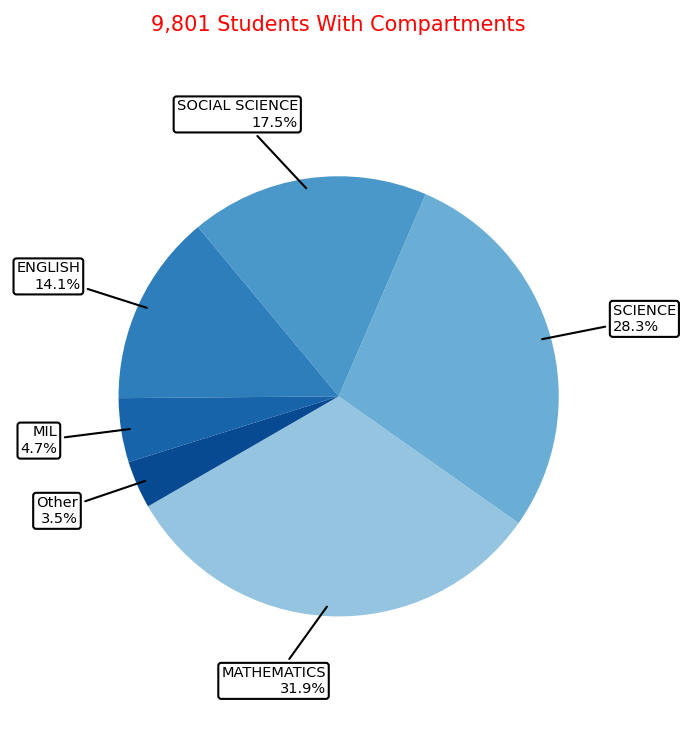

In [33]:
def plot_subject_distribution(comp_df, threshold=2, figsize=(10, 7), dpi=300):
    # Filter and deduplicate
    comp_df_unique = comp_df[comp_df['compartmental_status'] == 'YES'].drop_duplicates(subset=['barcode', 'COMPSubject'])

    # Count and percent
    subject_counts = comp_df_unique['COMPSubject'].value_counts()
    subject_percentages = (subject_counts / subject_counts.sum() * 100).round(1)

    # Group small values
    subject_data = subject_percentages[subject_percentages >= threshold]
    other_total = subject_percentages[subject_percentages < threshold].sum()
    if other_total > 0:
        subject_data['Other'] = other_total

    # Labels and sizes
    labels = subject_data.index.tolist()
    sizes = subject_data.values.tolist()
    total_students = comp_df_unique['barcode'].nunique()

    # Colors
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(sizes)))

    fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
    wedges, texts = ax.pie(
        sizes,
        startangle=210,
        colors=colors,
        labels=None,
        autopct=None,
        pctdistance=0.7,    # closer % text
        radius=0.85         # slightly tighter pie
    )

    # Adjust label offsets (reduced spacing)
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ha = 'left' if x > 0 else 'right'

        offset = 1.1  # reduced from 1.4
        ax.annotate(
            f"{label}\n{sizes[i]:.1f}%",
            xy=(x * 0.8, y * 0.8),
            xytext=(x * offset, y * offset),
            ha=ha, va='center',
            fontsize=7,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black"),
            arrowprops=dict(arrowstyle='-', color='black')
        )

    # Title
    plt.title(f"{total_students:,} Students With Compartments", fontsize=10, color='red', pad=20)
    plt.tight_layout()
    plt.show()
plot_subject_distribution(merged_comp_df)

In [ ]:
# Pivot table - unique compartment students per subject per year
subject_year_counts = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'COMPSubject', 'academic_year']
].drop_duplicates(subset=['barcode', 'COMPSubject'])

subject_pivot = subject_year_counts.pivot_table(
    index='COMPSubject',
    columns='academic_year',
    values='barcode',
    aggfunc='nunique',
    fill_value=0
)

# Get total compartments per year (unique students)
total_per_year = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'academic_year']
].drop_duplicates(subset='barcode').groupby('academic_year')['barcode'].count()

# Calculate percentage contribution
subject_percentage = subject_pivot.divide(total_per_year, axis=1) * 100
subject_percentage = subject_percentage.round(1).reset_index()
subject_percentage = subject_percentage.sort_values(by=subject_percentage.columns[1], ascending=False)

# Display the result
print(subject_percentage.to_string(index=False))

                 COMPSubject  2018  2019  2020  2021  2022  2023  2024
                 MATHEMATICS  75.3  61.5  59.2  69.7  66.2  60.5  58.4
                     SCIENCE  74.5  65.4  54.0  46.5  38.3  37.3  48.5
              SOCIAL SCIENCE  59.7  48.9  25.9  28.9  14.9  16.1  10.0
                     ENGLISH  29.4  37.8  24.9  45.3  21.6  27.7  16.1
                         MIL   6.5   8.1  11.8  22.8  12.8  12.4   5.4
                    SANSKRIT   2.8   2.5   5.5  14.0   6.0   2.5   1.1
SAMANYA BAKYARAN AND DARSHAN   1.4   0.0   0.0   0.0   0.0   0.0   0.0
                       HINDI   1.0   1.7   4.0   4.9  10.4   2.2   1.6
                         VOD   0.0   0.0   0.5   2.0   0.8   0.5   0.5


## 4. Bar Chart: Top 5 Subjects by Year

What share of the total compartment entries did each subject contribute in each year?

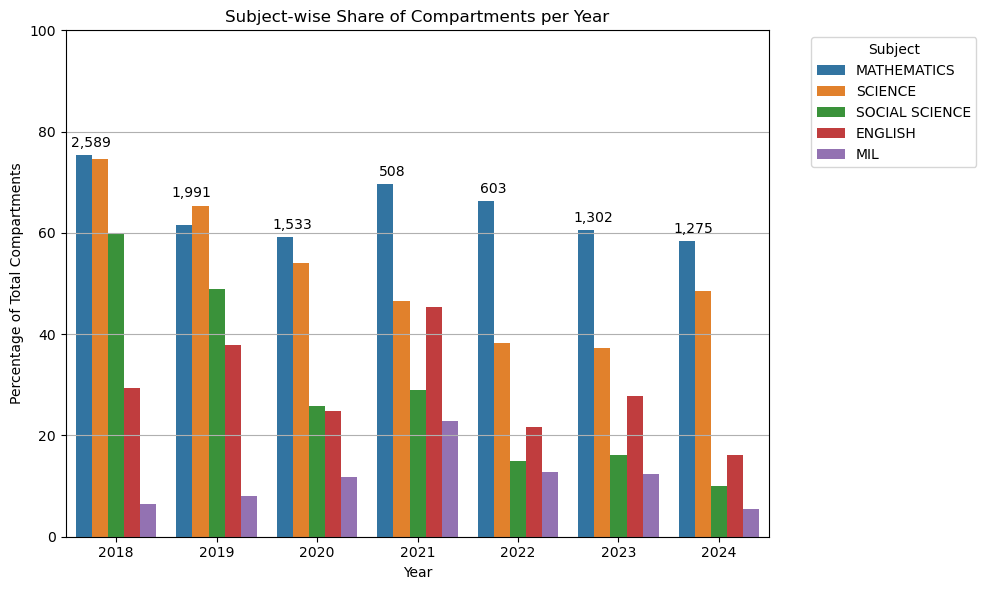

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt the subject_percentage DataFrame
melted = subject_percentage.melt(
    id_vars='COMPSubject',
    var_name='Academic Year',
    value_name='Percentage'
)

# Filter top N subjects if needed
top_subjects = ['MATHEMATICS', 'SCIENCE', 'SOCIAL SCIENCE', 'ENGLISH', 'MIL']
melted = melted[melted['COMPSubject'].isin(top_subjects)]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=melted,
    x='Academic Year',
    y='Percentage',
    hue='COMPSubject'
)

plt.title('Subject-wise Share of Compartments per Year')
plt.ylabel('Percentage of Total Compartments')
plt.xlabel('Year')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 100)
plt.grid(axis='y')

# Annotate values on top of bars
# Mapping of year to total compartment count
# Get compartment counts per year from the existing dataframe
compartment_counts = yearly_compartments['Compartment Count'].astype(int)
years = yearly_compartments.index.astype(str)

# Add annotation text above grouped bars for each year
# Ensure we access counts by position, not by label
# Annotate above the tallest bar of each year
bar_heights = melted.groupby('Academic Year')['Percentage'].max().reset_index()
for i, (year, height) in enumerate(zip(bar_heights['Academic Year'], bar_heights['Percentage'])):
    count = int(compartment_counts.loc[year])
    ax.text(i - 0.25, height + 1, f"{count:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

How many students had compartments in each subject over the years?

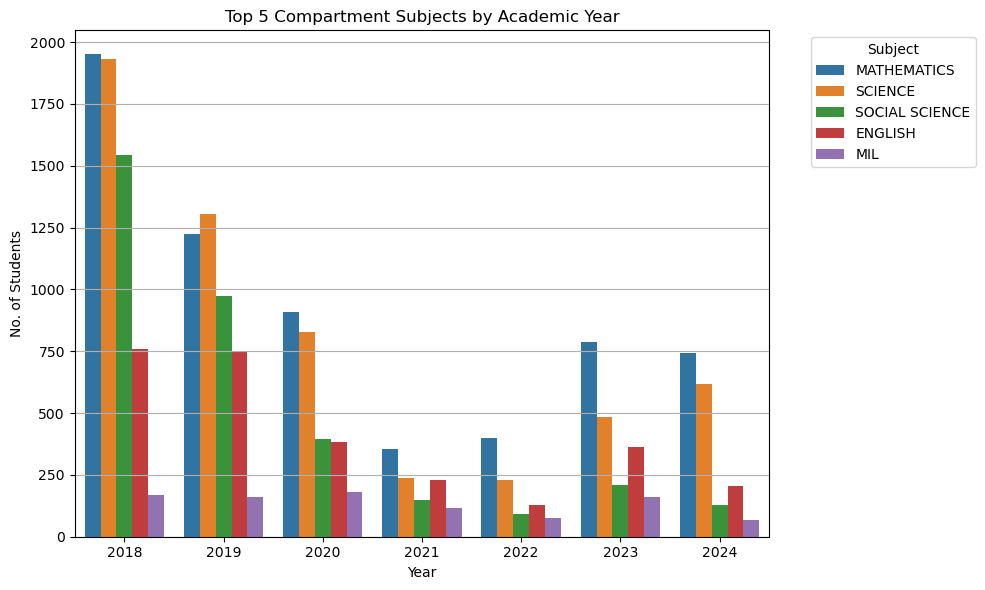

In [ ]:
# Filter top 5 subjects only
top5_subjects = subject_pivot.head(5)
top5_subjects_melted = top5_subjects.melt(
    id_vars='COMPSubject',
    value_vars=[col for col in top5_subjects.columns if str(col).isdigit()],
    var_name='Academic Year',
    value_name='Number of Students'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5_subjects_melted,
    x='Academic Year',
    y='Number of Students',
    hue='COMPSubject'
)

plt.title('Top 5 Compartment Subjects by Academic Year')
plt.ylabel('No. of Students')
plt.xlabel('Year')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [69]:
low_percent_df = merged_comp_df[
    (merged_comp_df['percentage'] < 30)
]

low_percent_df.head()

barcode  academic_year gender nationality   state   district  \
3290   19J0034545           2019   Male      Indian  Odisha  Sambalpur   
20684  19J0215228           2019   Male      Indian  Odisha    Koraput   
20685  19J0215228           2019   Male      Indian  Odisha    Koraput   
22296  19J0231736           2019   Male      Indian  Odisha     Ganjam   
54225  19J0560202           2019   Male      Indian  Odisha    Nuapada   

                    block social_category  \
3290       Kuchinda (NAC)             GEN   
20684       Koraput (MPL)              ST   
20685       Koraput (MPL)              ST   
22296           Chatrapur              SC   
54225  Khariar Road (NAC)              SC   

      examination_boardofthe_highest_qualification  \
3290                                   BSE, Odisha   
20684                              CBSE, New Delhi   
20685                              CBSE, New Delhi   
22296                                  BSE, Odisha   
54225                                  BSE, Odisha   

                board_exam_namefor_highest_qualification examination_type  \
3290   Board of Secondary Education, Orissa, Cuttack-...           Annual   
20684  Central Board of Secondary Education, Sikhya K...           Annual   
20685  Central Board of Secondary Education, Sikhya K...           Annual   
22296  Board of Secondary Education, Orissa, Cuttack-...           Annual   
54225  Board of Secondary Education, Orissa, Cuttack-...           Annual   

      year_of_passing  total_marks  secured_marks  percentage  \
3290             2019          600          175.0       29.17   
20684            2019          500          146.0   29.200001   
20685            2019          500          146.0   29.200001   
22296            2019          600          171.0        28.5   
54225            2019          600          123.0        20.5   

      compartmental_status  year_oqf_passing  COMPSubject COMPFailMark  \
3290                    NO              2019         None         None   
20684                  YES              2019  MATHEMATICS           21   
20685                  YES              2019      SCIENCE           16   
22296                   NO              2019         None         None   
54225                  YES              2019      ENGLISH           29   

      COMPPassMark  
3290          None  
20684           33  
20685           33  
22296         None  
54225           30

In [70]:
low_percent_summary = low_percent_df['compartmental_status'].value_counts()
print(low_percent_summary)


compartmental_status
NO     310
YES    154
Name: count, dtype: int64


In [118]:
# Logic: eligible for compartment if total marks ≥ 198 and subject fail
agg_pass = merged_comp_df['secured_marks'] >= 197.0
subject_fail = merged_comp_df['COMPFailMark'] < merged_comp_df['COMPPassMark']
expected_compartment = agg_pass & subject_fail

# Students who are marked as compartment but don’t meet criteria
should_not_be_comp = merged_comp_df[~expected_compartment & (merged_comp_df['compartmental_status'] == 'YES')]

print("\nStudents who are marked as 'YES' but do not meet the criteria:")
print(should_not_be_comp[['barcode', 'academic_year','secured_marks','COMPFailMark', 'COMPPassMark', 'compartmental_status']].to_string(index=False))


Students who are marked as 'YES' but do not meet the criteria:
    barcode  academic_year  secured_marks  COMPFailMark  COMPPassMark compartmental_status
 19J0001414           2019          218.0          17.0          17.0                  YES
 19J0001414           2019          218.0          23.0          23.0                  YES
 19J0011555           2019          228.0          15.0          15.0                  YES
 19J0011555           2019          228.0          29.0          29.0                  YES
 19J0026470           2019          254.0          20.0          20.0                  YES
 19J0026470           2019          254.0          15.0          15.0                  YES
 19J0026470           2019          254.0          25.0          25.0                  YES
 19J0034627           2019          222.0          22.0          22.0                  YES
 19J0049505           2019          264.0          12.0          12.0                  YES
 19J0049505           2019

In [102]:
print("\nStudents who are marked as 'YES' but do not meet the criteria:")
print(should_not_be_comp[['barcode', 'secured_marks', 'COMPFailMark', 'COMPPassMark', 'compartmental_status']].to_string(index=False))



Students who are marked as 'YES' but do not meet the criteria:
    barcode  secured_marks  COMPFailMark  COMPPassMark compartmental_status
 19J0001414          218.0          17.0          17.0                  YES
 19J0001414          218.0          23.0          23.0                  YES
 19J0011555          228.0          15.0          15.0                  YES
 19J0011555          228.0          29.0          29.0                  YES
 19J0026470          254.0          20.0          20.0                  YES
 19J0026470          254.0          15.0          15.0                  YES
 19J0026470          254.0          25.0          25.0                  YES
 19J0034627          222.0          22.0          22.0                  YES
 19J0049505          264.0          12.0          12.0                  YES
 19J0049505          264.0          23.0          23.0                  YES
 19J0089627          226.0          16.0          16.0                  YES
 19J0107656          273

In [53]:
# Filter to valid percentage values 
valid_df = merged_comp_df.loc[
    merged_comp_df['percentage'].between(0, 100) & merged_comp_df['percentage'].notna(),
    ['barcode', 'percentage', 'compartmental_status']
].drop_duplicates(subset='barcode')


# Create percentage brackets 
percentage_bracket = pd.cut(
    valid_df['percentage'],
    bins=[0, 20, 30, 50, 70, 100],
    labels=['<20%', '20-30%', '30–50%', '50–70%', '>70%'],
    include_lowest=True
)


summary = (
    valid_df.assign(Percentage=percentage_bracket)
    .groupby('Percentage', observed=True)
    .agg(
        Total_Students=('barcode', 'count'),
        With_Compartments=('compartmental_status', lambda x: (x == 'YES').sum())
    )
    .reset_index()
)

summary['% With Compartments'] = (
    100 * summary['With_Compartments'] / summary['Total_Students']
).round(2)
summary

Percentage  Total_Students  With_Compartments  % With Compartments
0       <20%              50                 12                24.00
1     20-30%             328                 37                11.28
2     30–50%         1405127               8040                 0.57
3     50–70%         1423422               1603                 0.11
4       >70%          624279                107                 0.02

## 6. Examination Board-wise Compartment Counts

In [ ]:
def count_compartment_students_by_board(df, exam_type_value):
    return (
        df.loc[
            (df['compartmental_status'] == 'YES') &
            (df['examination_type'] == exam_type_value),
            ['barcode', 'examination_boardofthe_highest_qualification']
        ]
        .drop_duplicates(subset='barcode')
        ['examination_boardofthe_highest_qualification']
        .value_counts(dropna=False)
        .loc[lambda x: x > 0]
        .reset_index()
        .rename(columns={
            'index': 'Examination Board',
            'examination_boardofthe_highest_qualification': 'Board Type' 
        })
    )

In [198]:
board_counts_annual = count_compartment_students_by_board(merged_comp_df, 'Annual')
board_counts_supplementary = count_compartment_students_by_board(merged_comp_df, 'Supplementary')

In [199]:
board_counts_annual.head()

Board Type  count
0  CBSE, New Delhi   1968
1      BSE, Odisha   1967
2  ICSE, New Delhi     29
3  NIOS, New Delhi     14
4   OSBME,  Odisha     10

In [200]:
board_counts_supplementary.head()

Board Type  count
0      BSE, Odisha   3704
1  CBSE, New Delhi   2000
2  ICSE, New Delhi     34
3     SOSC, Odisha      7
4  NIOS, New Delhi      4

## 7. Examination Type-wise Compartment Counts


In [196]:
# Step 1: Filter students with compartmental status = 'YES'
comp_students = merged_comp_df[merged_comp_df['compartmental_status'] == 'YES']

# Step 2: Drop duplicate barcodes to avoid double-counting the same student
comp_students_unique = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'examination_type']
].drop_duplicates(subset='barcode')

# Step 3: Count unique students by examination type
exam_type_counts = (
    comp_students_unique['examination_type']
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={
        'index': 'Examination Type',
        'examination_type': 'Type of exam'
    })
)

exam_type_counts

Type of exam  count
0  Supplementary   5767
1         Annual   4034

In [195]:
# Step 1: Drop duplicates to ensure one count per student
comp_students_unique = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'examination_boardofthe_highest_qualification']
].drop_duplicates(subset='barcode')

# Step 2: Group by examination board and count unique students
board_counts = (
    comp_students_unique['examination_boardofthe_highest_qualification']
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={
        'examination_boardofthe_highest_qualification': 'Exam board'
    })
)

print(board_counts.head(10).to_string(index=False))


         Exam board  count
        BSE, Odisha   5671
    CBSE, New Delhi   3968
    ICSE, New Delhi     63
    NIOS, New Delhi     18
       SOSC, Odisha     14
     OSBME,  Odisha     12
       SJSU, Odisha     11
BSE, Andhra Pradesh      9
     JAC, Jharkhand      9
       SIOS, Odisha      6


In [50]:
# Filter and deduplicate by student and subject
comp_data = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'district', 'COMPSubject']
].drop_duplicates(subset=['barcode', 'COMPSubject'])

# Pivot table — subject-wise counts by district
district_subject_table = comp_data.pivot_table(
    index='district',
    columns='COMPSubject',
    values='barcode',
    aggfunc='nunique',
    fill_value=0
)

# Add total column (number of unique students with compartments per district)
district_totals = merged_comp_df.loc[
    merged_comp_df['compartmental_status'] == 'YES',
    ['barcode', 'district']
].drop_duplicates(subset='barcode').groupby('district').size()

district_subject_table['Student_Comp_Total'] = district_totals

district_subject_table = district_subject_table.sort_values(by='Student_Comp_Total', ascending=False).reset_index()
print(district_subject_table.to_string(index=False))


     district  ENGLISH  HINDI  MATHEMATICS  MIL  SAMANYA BAKYARAN AND DARSHAN  SANSKRIT  SCIENCE  SOCIAL SCIENCE  VOD  Student_Comp_Total
   Mayurbhanj      228     18          540   74                             2        39      594             404    4                 847
   Sundargarh      187     17          558   70                             0        12      517             326    0                 776
      Koraput      106     22          489   44                             0         7      394             197    3                 732
       Khurda      187     15          440   36                             0        16      405             246    1                 610
      Cuttack      278     11          332   39                             2        13      288             198    0                 595
       Ganjam      191     22          344   61                             0        31      282             173    7                 546
    Kalahandi       83     16     

C:\Users\Admin\AppData\Local\Temp\ipykernel_24392\3122315233.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  district_subject_table = comp_data.pivot_table(
C:\Users\Admin\AppData\Local\Temp\ipykernel_24392\3122315233.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].drop_duplicates(subset='barcode').groupby('district').size()


In [32]:
district_subject_table.to_excel('district_subject_compartments.xlsx', index=False)


In [119]:
option_df.head()

barcode                                  ReportedInstitute  SAMSCode  \
0  18J0000045  Gangadhar Meher Higher Secondary School, Samba...  28141101   
1  18J0000045  Netaji Subash Chandra Bose Higher Secondary Sc...  28111101   
2  18J0000045           Hirakud Higher Secondary School, Hirakud  28132101   
3  18J0000045         Surajmal Higher Secondary School, Rampella  28112102   
4  18J0000045        Burla N.A.C. Higher Secondary School, Burla  28122101   

     Stream InstituteDistrict  InstituteBlock  \
0  Commerce         Sambalpur  Sambalpur (MC)   
1  Commerce         Sambalpur         Rengali   
2  Commerce         Sambalpur   Hirakud (NAC)   
3  Commerce         Sambalpur         Rengali   
4  Commerce         Sambalpur     Burla (NAC)   

                   TypeofInstitute Phase  Year AdmissionStatus OptionNo  
0                      Govt. (SME)     1  2018        TC TAKEN        1  
1                      Govt. (SME)     1  2018    NOT SELECTED        2  
2  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        3  
3  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        4  
4  Non-Govt Aided (488 Categories)     1  2018    NOT SELECTED        5

In [121]:
merged_option_df = df.merge(option_df, on = ['barcode'], how  = 'left')

In [123]:
merged_df = merged_option_df.merge(merged_comp_df, on=['barcode', 'academic_year'], how='left')

In [124]:
merged_df.columns


Index(['barcode', 'academic_year', 'gender_x', 'nationality_x', 'state_x',
       'district_x', 'block_x', 'social_category_x',
       'examination_boardofthe_highest_qualification_x',
       'board_exam_namefor_highest_qualification_x', 'examination_type_x',
       'year_of_passing_x', 'total_marks_x', 'secured_marks_x', 'percentage_x',
       'compartmental_status_x', 'year_oqf_passing_x', 'ReportedInstitute',
       'SAMSCode', 'Stream', 'InstituteDistrict', 'InstituteBlock',
       'TypeofInstitute', 'Phase', 'Year', 'AdmissionStatus', 'OptionNo',
       'gender_y', 'nationality_y', 'state_y', 'district_y', 'block_y',
       'social_category_y', 'examination_boardofthe_highest_qualification_y',
       'board_exam_namefor_highest_qualification_y', 'examination_type_y',
       'year_of_passing_y', 'total_marks_y', 'secured_marks_y', 'percentage_y',
       'compartmental_status_y', 'year_oqf_passing_y', 'COMPSubject',
       'COMPFailMark', 'COMPPassMark', 'compartment_logic'],
      

## Visulisation


In [16]:
df.columns

Index(['barcode', 'academic_year', 'gender', 'nationality', 'state',
       'district', 'block', 'social_category',
       'examination_boardofthe_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status'],
      dtype='object')

In [17]:
df.head(3)

barcode  academic_year  gender nationality   state    district  \
0  19J0000019           2019    Male      Indian  Odisha    Rayagada   
1  19J0000026           2019    Male      Indian  Odisha  Kendrapara   
2  19J0000031           2019  Female      Indian  Odisha     Bhadrak   

      block social_category examination_boardofthe_highest_qualification  \
0   Gunupur             GEN                                  BSE, Odisha   
1  Rajnagar             OBC                                  BSE, Odisha   
2     Bonth              SC                                  BSE, Odisha   

  examination_type  year_of_passing  total_marks  secured_marks  percentage  \
0           Annual             2019          600          221.0   36.830002   
1           Annual             2019          600          208.0   34.669998   
2           Annual             2019          600          198.0        33.0   

  compartmental_status  
0                   NO  
1                   NO  
2                   NO

In [18]:
# Group by academic_year and gender
gender_counts = df.groupby(['academic_year', 'gender']).size().unstack(fill_value=0)
gender_counts = gender_counts.reindex(columns=['Male', 'Female', 'Transgender'], fill_value=0)
gender_counts['total'] = gender_counts.sum(axis=1)
summary_df = gender_counts[['total', 'Male', 'Female', 'Transgender']].reset_index()
summary_df.columns = ['Year', 'Total', 'Male', 'Female', 'Trans']
summary_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_23480\3571935236.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_counts = df.groupby(['academic_year', 'gender']).size().unstack(fill_value=0)


Year   Total    Male  Female  Trans
0  2018  439528  223360  216166      2
1  2019  411118  204306  206807      5
2  2020  431636  213432  218191     13
3  2021  498180  249788  248340     52
4  2022  574238  287537  286644     57
5  2023  560769  279878  280835     56
6  2024  537932  259620  278290     22

C:\Users\Admin\AppData\Local\Temp\ipykernel_23480\3727017686.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_trend = df.groupby(['academic_year', 'gender']).size().unstack(fill_value=0)


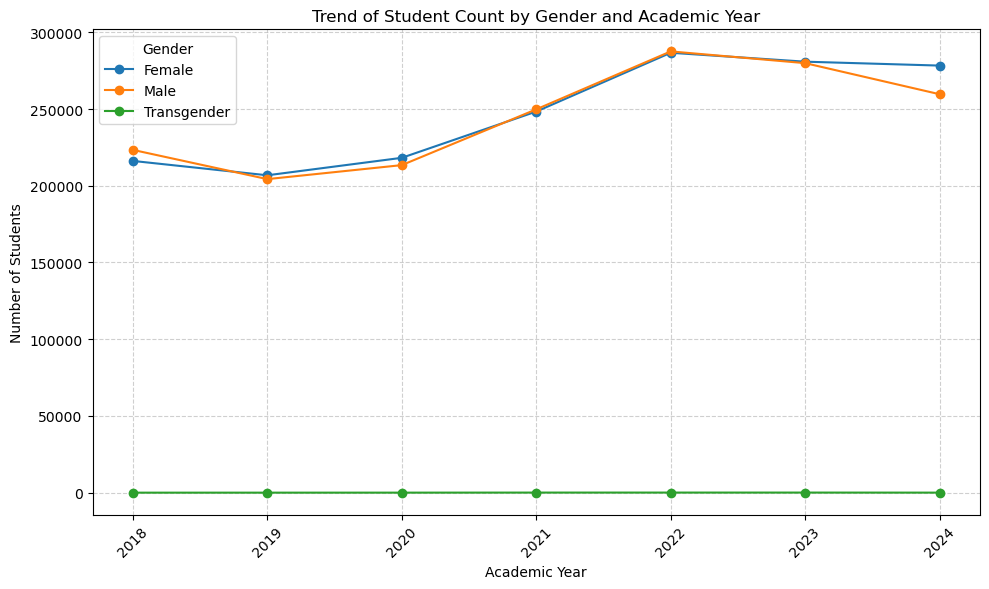

In [19]:
# Group by year and gender
gender_trend = df.groupby(['academic_year', 'gender']).size().unstack(fill_value=0)

# Sort by academic_year
gender_trend = gender_trend.sort_index()

# Plot line chart
plt.figure(figsize=(10, 6))
for gender in gender_trend.columns:
    plt.plot(gender_trend.index, gender_trend[gender], marker='o', label=gender)

plt.title("Trend of Student Count by Gender and Academic Year")
plt.xlabel("Academic Year")
plt.ylabel("Number of Students")
plt.legend(title="Gender")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# Group by academic_year, gender, and compartmental_status
gender_comp = df.groupby(['academic_year', 'gender', 'compartmental_status']).size().unstack(fill_value=0)
gender_comp = gender_comp.rename(columns={'NO': 'Passed', 'YES': 'Failed'})

# Pivot gender-wise pass/fail into wide format
result = {}

for gender, prefix in zip(['Male', 'Female', 'Transgender'], ['Male', 'Female', 'Trans']):
    temp = gender_comp.loc[gender_comp.index.get_level_values('gender') == gender].droplevel('gender')
    temp = temp.rename(columns={'Passed': f'{prefix}_Passed', 'Failed': f'{prefix}_Failed'})
    result[gender] = temp

# Total pass/fail counts across all genders
total_df = df.groupby(['academic_year', 'compartmental_status']).size().unstack(fill_value=0)
total_df = total_df.rename(columns={'NO': 'Passed', 'YES': 'Failed'})

# Combine all into one table
final_table = total_df.join([result['Male'], result['Female'], result['Transgender']], how='outer')
final_table = final_table.fillna(0).astype(int).sort_index().reset_index()
final_table = final_table.rename(columns={'academic_year': 'Year'})

# Show the table
print(final_table.to_string(index=False))

C:\Users\Admin\AppData\Local\Temp\ipykernel_23480\254449025.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_comp = df.groupby(['academic_year', 'gender', 'compartmental_status']).size().unstack(fill_value=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23480\254449025.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_df = df.groupby(['academic_year', 'compartmental_status']).size().unstack(fill_value=0)


 Year  Passed  Failed  Male_Passed  Male_Failed  Female_Passed  Female_Failed  Trans_Passed  Trans_Failed
 2018  436939    2589       222147         1213         214790           1376             2             0
 2019  409127    1991       203338          968         205784           1023             5             0
 2020  430103    1533       212619          813         217471            720            13             0
 2021  497672     508       249521          267         248099            241            52             0
 2022  573635     603       287198          339         286380            264            57             0
 2023  559467    1302       279165          713         280246            589            56             0
 2024  536657    1275       258984          636         277651            639            22             0


In [21]:
# Calculate the counts
overall = df['gender'].value_counts()
passed = df[df['compartmental_status'] == 'NO']['gender'].value_counts()
failed = df[df['compartmental_status'] == 'YES']['gender'].value_counts()

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    'Overall': overall,
    'Passed': passed,
    'Failed': failed
}).fillna(0).astype(int)

# Optional: reorder columns
summary_df = summary_df[['Overall', 'Passed', 'Failed']]

# Display the result
summary_df


Overall   Passed  Failed
gender                               
Female       1735273  1730421    4852
Male         1717921  1712972    4949
Transgender      207      207       0

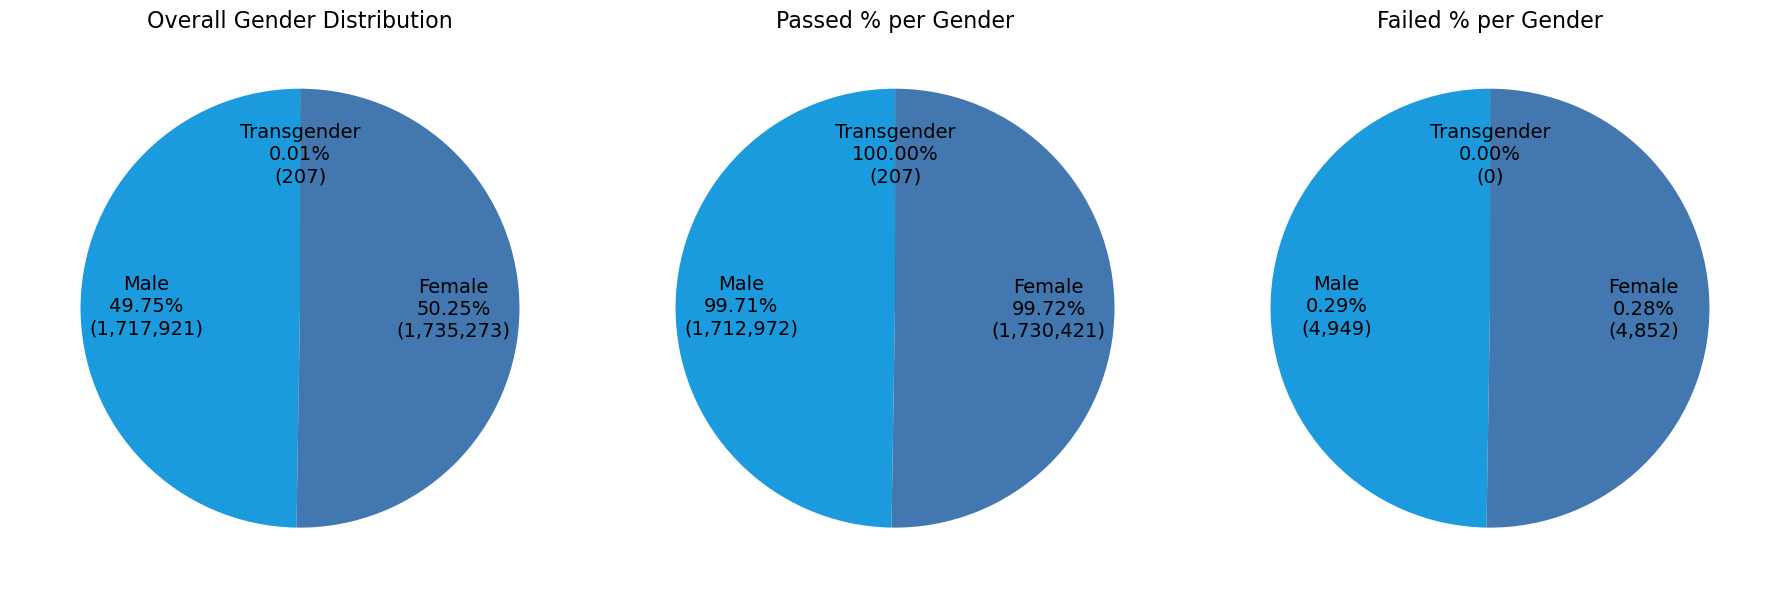

In [22]:
import matplotlib.pyplot as plt

def gender_plot_by_pass_fail_ratio(df):
    gender_categories = ['Male', 'Female', 'Transgender']
    pastel_colors = ["#1c9ade", "#4277b0", "#c1b806"]

    # Clean columns
    df['gender'] = df['gender'].str.title().str.strip()
    df['compartmental_status'] = df['compartmental_status'].str.upper().str.strip()

    # Get total, passed, and failed counts
    total_counts = df['gender'].value_counts().reindex(gender_categories, fill_value=0)
    passed_counts = df[df['compartmental_status'] == 'NO']['gender'].value_counts().reindex(gender_categories, fill_value=0)
    failed_counts = df[df['compartmental_status'] == 'YES']['gender'].value_counts().reindex(gender_categories, fill_value=0)

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Pie 1: Overall Gender Distribution (percent of total)
    def make_autopct_total(values):
        def inner_autopct(pct):
            index = inner_autopct.idx
            label = gender_categories[index]
            count = values[index]
            total = sum(values)
            percent = (count / total) * 100
            inner_autopct.idx += 1
            return f"{label}\n{percent:.2f}%\n({count:,})"
        
        inner_autopct.idx = 0
        return inner_autopct

    axes[0].pie(
        total_counts.values,
        labels=None,
        colors=pastel_colors,
        autopct=make_autopct_total(total_counts.values),
        startangle=90,
        textprops={'fontsize': 14},
        pctdistance=0.7
    )
    axes[0].set_title("Overall Gender Distribution", fontsize=16)

    # Pie 2 & 3: Passed and Failed % within each gender group
    def make_autopct_group(values, totals):
        def inner_autopct(pct):
            index = inner_autopct.idx
            label = gender_categories[index]
            count = values[index]
            total = totals[index]
            ratio = (count / total) * 100 if total > 0 else 0
            inner_autopct.idx += 1
            return f"{label}\n{ratio:.2f}%\n({count:,})"
        inner_autopct.idx = 0
        return inner_autopct

    # Pie 2: Passed % per gender
    axes[1].pie(
        total_counts.values,
        labels=None,
        colors=pastel_colors,
        autopct=make_autopct_group(passed_counts.values, total_counts.values),
        startangle=90,
        textprops={'fontsize': 14},
        pctdistance=0.7
    )
    axes[1].set_title("Passed % per Gender", fontsize=16)

    # Pie 3: Failed % per gender
    axes[2].pie(
        total_counts.values,
        labels=None,
        colors=pastel_colors,
        autopct=make_autopct_group(failed_counts.values, total_counts.values),
        startangle=90,
        textprops={'fontsize': 14},
        pctdistance=0.7
    )
    axes[2].set_title("Failed % per Gender", fontsize=16)

    for ax in axes:
        ax.axis('equal')

    plt.tight_layout()
    plt.show()
gender_plot_by_pass_fail_ratio(df)

In [33]:
df.columns

Index(['barcode', 'academic_year', 'gender', 'nationality', 'state',
       'district', 'block', 'social_category',
       'examination_boardofthe_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'computed_pct'],
      dtype='object')

In [24]:
# First, coerce marks columns to numeric
df['secured_marks'] = pd.to_numeric(df['secured_marks'], errors='coerce')
df['total_marks'] = pd.to_numeric(df['total_marks'], errors='coerce')
df['percentage'] = pd.to_numeric(df['percentage'], errors='coerce')

# Calculate actual percentage
df['computed_pct'] = (df['secured_marks'] / df['total_marks']) * 100

# Check where difference is large (e.g., more than 1% error)
wrong_pct = df[np.abs(df['computed_pct'] - df['percentage']) > 1]

# Also check any percentage > 100
over_100 = df[df['percentage'] > 100]

print(f"Total rows with wrong percentage: {len(wrong_pct)}")
print(f"Rows with percentage > 100: {len(over_100)}")


Total rows with wrong percentage: 0
Rows with percentage > 100: 193


In [25]:
df = df[df['percentage'] <= 100]

In [26]:
# Group by academic_year and gender, and calculate average percentage
avg_percentage = df.groupby(['academic_year', 'gender'])['percentage'].mean().unstack()

# Optional: sort by year if not already
avg_percentage = avg_percentage.sort_index()

# Show the table
avg_percentage


gender            Female       Male  Transgender
academic_year                                   
2018           54.027431  53.413742    47.665001
2019           51.056385  50.666615    36.625999
2020           47.171589  46.918571    48.591537
2021           56.845116  54.982819    55.722309
2022           64.921936  63.078289    57.675087
2023           60.075111   57.99725    54.662144
2024           54.042446  52.167793    53.282726

In [27]:
low_perf_rate = (
    df[df['percentage'] < 33]
    .groupby(['academic_year', 'gender'])
    .size()
    .div(df.groupby(['academic_year', 'gender']).size())
    .unstack() * 100
)

low_perf_rate

gender           Female      Male  Transgender
academic_year                                 
2018           0.019431  0.023729          NaN
2019           0.015473  0.033283          NaN
2020           0.025673  0.025313          NaN
2021           0.035838  0.044037          NaN
2022           0.017792  0.023649     1.754386
2023           0.014599  0.012863          NaN
2024           0.017967  0.013866          NaN

In [ ]:
df['social_category'].value_counts()

social_category
GEN     815070
ST      772238
OBC     768803
SC      605109
SEBC    491988
Name: count, dtype: int64

In [38]:
# Standardize social_category
df['social_category'] = df['social_category'].str.upper().str.strip()

# Aggregate metrics
summary = df.groupby('social_category').agg(
    Total_Count=('social_category', 'size'),
    Passed=('compartmental_status', lambda x: (x.str.upper() == 'NO').sum()),
    Failed=('compartmental_status', lambda x: (x.str.upper() == 'YES').sum()),
    Avg_Percentage=('percentage', 'mean')
)

# Add percentage of total
summary['% of Total Students'] = (summary['Total_Count'] / summary['Total_Count'].sum() * 100).round(2)

# Add pass/fail rates
summary['Pass Rate (%)'] = (summary['Passed'] / summary['Total_Count'] * 100).round(2)
summary['Fail Rate (%)'] = (summary['Failed'] / summary['Total_Count'] * 100).round(2)

# Final formatting
summary = summary.reset_index().rename(columns={
    'social_category': 'Social Category',
    'Total_Count': 'Total Count',
    'Avg_Percentage': 'Avg %'
})

summary = summary[['Social Category', 'Total Count', 'Passed', 'Failed',
                   '% of Total Students', 'Avg %', 'Pass Rate (%)', 'Fail Rate (%)']]

summary


Social Category  Total Count  Passed  Failed  % of Total Students  \
0             GEN       815070  811241    3829                23.60   
1             OBC       768803  767592    1211                22.26   
2              SC       605109  603249    1860                17.52   
3            SEBC       491988  491508     480                14.25   
4              ST       772238  769819    2419                22.36   

       Avg %  Pass Rate (%)  Fail Rate (%)  
0  57.656693          99.53           0.47  
1  57.065483          99.84           0.16  
2  52.388725          99.69           0.31  
3  58.517971          99.90           0.10  
4   51.48045          99.69           0.31

In [224]:
# Clean column for safety
df['social_category'] = df['social_category'].str.upper().str.strip()

# Define stats to calculate
summary_stats = df.groupby('social_category')['percentage'].agg(
    Mean_Percentage='mean',
    Median_Percentage='median',
    Std_Deviation='std',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    Min='min',
    Max='max'
).round(2).reset_index()

summary_stats

social_category  Mean_Percentage  Median_Percentage  Std_Deviation  \
0             GEN            57.66          56.669998          15.54   
1             OBC            57.07          56.330002          14.75   
2              SC        52.389999          50.830002          13.74   
3            SEBC            58.52               58.0          14.66   
4              ST            51.48               50.0          12.99   

          Q1         Q3   Min    Max  
0  44.830002  69.830002  0.54  100.0  
1  45.330002  68.169998  5.38  100.0  
2       41.0  62.169998  3.63  100.0  
3       47.0       70.0  19.0  100.0  
4  40.669998  60.669998   3.3  100.0

In [18]:
from sams.utils import load_data
from sams.config import datasets
iti_enrollments = load_data(datasets["iti_enrollments"])
iti_marks = load_data(datasets["iti_marks"])
iti_institutes_cutoffs = load_data(datasets["iti_institutes_cutoffs"])
iti_institutes_enrollments = load_data(datasets["iti_institutes_enrollments"])
iti_institutes_strength = load_data(datasets["iti_institutes_strength"])
diploma_enrollments = load_data(datasets["diploma_enrollments"])
diploma_marks = load_data(datasets["diploma_marks"])
diploma_institutes_enrollments = load_data(datasets["diploma_institutes_enrollments"])
diploma_institutes_strength = load_data(datasets["diploma_institutes_strength"])
hss_marks = load_data(datasets["hss_marks"])
deg_applications = load_data(datasets["deg_applications"])
deg_enrollments = load_data(datasets["deg_enrollments"])
deg_marks = load_data(datasets["deg_marks"])

2025-09-04 18:00:01.328 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_enrollments.pq
2025-09-04 18:00:03.044 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_marks.pq
2025-09-04 18:00:03.617 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_institutes_cutoffs.pq
2025-09-04 18:00:04.410 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_institutes_enrollments.pq
2025-09-04 18:00:04.422 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\iti_institutes_strength.pq
2025-09-04 18:00:04.431 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\diploma_enrollments.pq
2025-09-04 18:00:06.505 | INFO     | sams.utils:load_data:70 - Loading data 

In [5]:
option_df = pd.read_parquet(RAW_DATA_DIR / "hss_applications.pq", engine='pyarrow')


In [2]:
from sams.utils import load_data
from sams.config import datasets
hss_applications = load_data(datasets["hss_applications"])

2025-09-23 15:34:13.858 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-09-23 15:34:13.918 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-09-23 15:34:13.918 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


2025-09-23 15:34:16.050 | INFO     | sams.utils:load_data:75 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_applications.pq


In [6]:
option_df.shape

(18323940, 14)

In [7]:
option_df.head()

aadhar_no     barcode  academic_year  \
0      <NA>  18J0000045           2018   
1      <NA>  18J0000045           2018   
2      <NA>  18J0000045           2018   
3      <NA>  18J0000045           2018   
4      <NA>  18J0000045           2018   

                                  reported_institute sams_code    stream  \
0  Gangadhar Meher Higher Secondary School, Samba...  28141101  Commerce   
1  Netaji Subash Chandra Bose Higher Secondary Sc...  28111101  Commerce   
2           Hirakud Higher Secondary School, Hirakud  28132101  Commerce   
3         Surajmal Higher Secondary School, Rampella  28112102  Commerce   
4        Burla N.A.C. Higher Secondary School, Burla  28122101  Commerce   

  institute_district institute_block                type_of_institute phase  \
0          Sambalpur  Sambalpur (MC)                      Govt. (SME)     1   
1          Sambalpur         Rengali                      Govt. (SME)     1   
2          Sambalpur   Hirakud (NAC)  Non-Govt Aided (488 Categories)     1   
3          Sambalpur         Rengali  Non-Govt Aided (488 Categories)     1   
4          Sambalpur     Burla (NAC)  Non-Govt Aided (488 Categories)     1   

   year admission_status option_no  num_applications  
0  2018         TC TAKEN         1                 5  
1  2018     NOT SELECTED         2                 5  
2  2018     NOT SELECTED         3                 5  
3  2018     NOT SELECTED         4                 5  
4  2018     NOT SELECTED         5                 5

In [3]:
hss_applications.head()

aadhar_no     barcode  academic_year  \
0  L–ÁŸ’ÅÞu÷RÎ×à„³æ·™¯(u”q‡ûé>©†  23H2087289           2023   
1  L–ÁŸ’ÅÞu÷RÎ×à„³æ·™¯(u”q‡ûé>©†  23H2087289           2023   
2  L–ÁŸ’ÅÞu÷RÎ×à„³æ·™¯(u”q‡ûé>©†  23H2087289           2023   
3  L–ÁŸ’ÅÞu÷RÎ×à„³æ·™¯(u”q‡ûé>©†  23H2087289           2023   
4  L–ÁŸ’ÅÞu÷RÎ×à„³æ·™¯(u”q‡ûé>©†  23H2087289           2023   

                                  reported_institute sams_code    stream  \
0       Government Higher Secondary School, Rourkela  30101101      Arts   
1  Panchayat Samiti Higher Secondary School, Nuagaon  30089101  Commerce   
2  Panchayat Samiti Higher Secondary School, Nuagaon  30089101      Arts   
3            Ispat Higher Secondary School, Rourkela  30102101      Arts   
4  Sushilabati Government Women's Higher Secondar...  30101203      Arts   

  institute_district institute_block                type_of_institute phase  \
0         Sundargarh   Rourkela (MC)                      Govt. (SME)     1   
1         Sundargarh         Nuagaon  Non-Govt Aided (662 Categories)     1   
2         Sundargarh         Nuagaon  Non-Govt Aided (662 Categories)     1   
3         Sundargarh   Rourkela (MC)  Non-Govt Aided (488 Categories)     1   
4         Sundargarh   Rourkela (MC)                      Govt. (SME)     1   

   year admission_status option_no  num_applications  
0  2023     NOT SELECTED         5                 5  
1  2023         TC TAKEN         2                 5  
2  2023     NOT SELECTED         1                 5  
3  2023     NOT SELECTED         4                 5  
4  2023     NOT SELECTED         3                 5

In [24]:
option_df.columns

Index(['aadhar_no', 'barcode', 'academic_year', 'gender', 'nationality',
       'state', 'district', 'block', 'pin_code', 'social_category',
       'examination_boardofthe_highest_qualification',
       'board_exam_namefor_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details'],
      dtype='object')

In [ ]:
conn = sqlite3.connect(db_path)

query = """
SELECT
    barcode,
    aadhar_no,
    gender,
    dob,
    option_data
FROM students
WHERE module = 'ITI';
"""

students_df = pd.read_sql_query(query, conn)
conn.close()

students_df.head()

barcode                                     aadhar_no gender  \
0  17T0181047  DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=   Male   
1  17T0114510  6/Vau/OfdeJ6NAV7iD6bmnbzGEexPB8LP/JcN1eroCs=   Male   
2  17T0346747  EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=   Male   
3  17T0288737  yg4tiEAGopVFYnXgybQlTen34PqwEI08id2hvZS9spw=   Male   
4  17T0151332  5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=   Male   

           dob annual_income   state   district      social_category domicile  \
0  01-Jan-2002    0-1,00,000  Odisha      Angul  Schedule Caste (SC)       NA   
1  20-Apr-2000    0-1,00,000  Odisha  Dhenkanal              General       NA   
2  07-Oct-2001    0-1,00,000  Odisha  Dhenkanal             OBC/SEBC       NA   
3  05-Nov-1999    0-1,00,000  Odisha  Dhenkanal  Schedule Caste (SC)       NA   
4  20-Apr-1999    0-1,00,000  Odisha    Deogarh  Schedule Tribe (ST)       NA   

  date_of_application  ...  es  sports national_cadet_corps orphan ews  \
0         01-Jun-2017  ...  No      No                   NA     No  NA   
1         26-May-2017  ...  No      No                   NA     No  NA   
2         20-Jul-2017  ...  No      No                   NA     No  NA   
3         08-Jun-2017  ...  No      No                   NA     No  NA   
4         30-May-2017  ...  No      No                   NA     No  NA   

  admission_status enrollment_status phase  \
0              Yes               Yes  None   
1              Yes               Yes  None   
2              Yes               Yes  None   
3              Yes               Yes  None   
4              Yes               Yes  None   

                                           mark_data  \
0  [{"ExamName": "10th Pass", "YearofPassing": "2...   
1  [{"ExamName": "10th Pass", "YearofPassing": "2...   
2  [{"ExamName": "10th Pass", "YearofPassing": "2...   
3  [{"ExamName": "10th Pass", "YearofPassing": "2...   
4  [{"ExamName": "10th Pass", "YearofPassing": "2...   

                                         option_data  
0  [{"Phase": "1", "Option_No": "1", "Institute_N...  
1  [{"Phase": "1", "Option_No": "1", "Institute_N...  
2  [{"Phase": "1", "Option_No": "1", "Institute_N...  
3  [{"Phase": "1", "Option_No": "1", "Institute_N...  
4  [{"Phase": "1", "Option_No": "1", "Institute_N...  

[5 rows x 31 columns]

In [ ]:
conn = sqlite3.connect(db_path)

query = """
SELECT
    barcode,
    deg_option_details,
    deg_compartments
FROM students
WHERE module = 'DEG';
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.head()